In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import pickle
import os
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from oauth2client import file, client, tools
from apiclient import errors
import base64
from datetime import datetime
import re

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
def FindEmail(input_string):
    
    try:
        emails_list = re.findall(r'([a-zA-Z0-9._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', input_string)
    except:
        emails_list = []
        
    return emails_list[0]

In [4]:
def FindNumbersBraket(input_string):
    
    try:
        numbers_list = re.findall(r"\[\d-\d+\]", input_string)
        
        numbers_list = [item.replace('[', '').replace(']', '') for item in numbers_list]
        
    except:
        numbers_list = ['']
        
        
    if len(numbers_list) == 0:
        numbers_list = ['']
        
    return numbers_list[0]

In [5]:
def DateConv(date_str):
    '''
    Input: 'Y-m-d H:M:S'
    '''
    
    ## datetime object
    date_object = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')

    ## timestamp
    ts = datetime.timestamp(date_object) 
    
    
    return ts, date_object

In [6]:
def GetCredentials():
    
    '''
    Reading (or asking for) credentials.
    Output: credentials
    '''
    
    ## Credentials

    cwd = os.getcwd()
    path_cred = os.path.join(cwd, 'gmail_credentials')

    # If modifying these scopes, delete the file token.pickle.
    SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']


    creds = None
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists(os.path.join(path_cred, 'token.pickle')):
        with open(os.path.join(path_cred, 'token.pickle'), 'rb') as token:
            creds = pickle.load(token)
            print('Credentials ok!')
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        print('Credentials not ok! Asking for one...')
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                os.path.join(path_cred, 'credentials.json'), SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open(os.path.join(path_cred, 'token.pickle'), 'wb') as token:
            pickle.dump(creds, token)
            
    return creds

In [7]:
def GetAttachments(service, user_id, mail_id, output_path):
    """Get and store attachment from Message with given id.

    Inputs: i)   service: Authorized Gmail API service instance.
            ii)  user_id: User's email address. The special value "me" can be used to indicate the authenticated user.
            iii) mail_id: ID of Message containing attachment.
    Output: i) a dictionary whose key is the mail_id and the value is a list containing
            all attachment filenames.
            ii) The files saved in the output path
    """
    
    ## list the filenames:
    attachment_dict = {mail_id:[]}
    
    try:
        message = service.users().messages().get(userId=user_id, id=mail_id).execute()
        

        
        for part in message['payload']['parts']:
            if part['filename']:
                ## getting the filename
                attachment_filename = part['filename']
                attachment_dict[mail_id].append(attachment_filename)
                if 'data' in part['body']:
                    data = part['body']['data']
                else:
                    att_id = part['body']['attachmentId']
                    att = service.users().messages().attachments().get(userId=user_id,\
                                                                       messageId=mail_id,id=att_id).execute()
                    data = att['data']
                file_data = base64.urlsafe_b64decode(data.encode('UTF-8'))
                
                
                final_path = os.path.join(output_path, str(mail_id))
                if os.path.isdir(final_path) == False:
                    os.mkdir(final_path)
                
                with open(os.path.join(final_path, attachment_filename), 'wb') as f:
                    f.write(file_data)
                    
                   

    except:
        print('An error occurred')
        pass
    
    
    
    return attachment_dict

In [8]:
def GetAttachments_v2(message, output_path):
    """Get and store attachment from Message with given id.

    Inputs: i)   service: Authorized Gmail API service instance.
            ii)  user_id: User's email address. The special value "me" can be used to indicate the authenticated user.
            iii) mail_id: ID of Message containing attachment.
    Output: i) a dictionary whose key is the mail_id and the value is a list containing
            all attachment filenames.
            ii) The files saved in the output path
    """
    
    
    mail_id = message['id']
    user_id = 'me'
    ## list the filenames:
    attachment_dict = {mail_id:[]}
    
    try:
        
        for part in message['payload']['parts']:
            if part['filename']:
                ## getting the filename
                attachment_filename = part['filename']
                
                
                if '.jpg' not in attachment_filename and '.png' not in attachment_filename:
                    attachment_dict[mail_id].append(attachment_filename)
                    if 'data' in part['body']:
                        data = part['body']['data']
                    else:
                        att_id = part['body']['attachmentId']
                        att = service.users().messages().attachments().get(userId=user_id,\
                                                                           messageId=mail_id,id=att_id).execute()
                        data = att['data']
                    file_data = base64.urlsafe_b64decode(data.encode('UTF-8'))


                    final_path = os.path.join(output_path, str(mail_id))
                    if os.path.isdir(final_path) == False:
                        os.mkdir(final_path)

                    with open(os.path.join(final_path, attachment_filename), 'wb') as f:
                        f.write(file_data)
                    
                   

    except:
        print('An error occurred. GetAttachments_v2')
        pass
    
    
    
    return attachment_dict

In [9]:
def GetMessage(service, user_id, msg_id):
  """Get a Message with given ID.

  Args:
    service: Authorized Gmail API service instance.
    user_id: User's email address. The special value "me"
    can be used to indicate the authenticated user.
    msg_id: The ID of the Message required.

  Returns:
    A Message.
  """
  try:
    message = service.users().messages().get(userId=user_id, id=msg_id).execute()

    print ('Message snippet: %s' % message['snippet'])

    return message
  except:
    print('An error occurred: %s' % error)


In [10]:
def GetMessage_v2(message):
    try:
        snippet = message['snippet']
    except:
        snippet = ''

    return snippet

In [11]:
def ListMessagesMatchingQuery(service, user_id, query=''):
  """List all Messages of the user's mailbox matching the query.

  Args:
    service: Authorized Gmail API service instance.
    user_id: User's email address. The special value "me"
    can be used to indicate the authenticated user.
    query: String used to filter messages returned.
    Eg.- 'from:user@some_domain.com' for Messages from a particular sender.

  Returns:
    List of Messages that match the criteria of the query. Note that the
    returned list contains Message IDs, you must use get with the
    appropriate ID to get the details of a Message.
  """
  try:
    response = service.users().messages().list(userId=user_id,
                                               q=query).execute()
    messages = []
    if 'messages' in response:
      messages.extend(response['messages'])

    while 'nextPageToken' in response:
      page_token = response['nextPageToken']
      response = service.users().messages().list(userId=user_id, q=query,
                                         pageToken=page_token).execute()
      messages.extend(response['messages'])

    return messages
  except:
    print ('An error occurred: %s' % error)

In [12]:
def GetBody(message):
    
    '''
    Gets the email body in text/string format.
    Input: i) message JSON
    Output: ii) the text
    '''
    
    part_dict = message['payload']['parts'][0]
    
    if 'data' in part_dict['body']:

        data = part_dict['body']['data']

    elif 'data' in part_dict['parts'][0]['body']:
        data = part_dict['parts'][0]['body']['data']
    elif 'data' in part_dict['parts'][0]['parts'][0]['body']:
        data = part_dict['parts'][0]['parts'][0]['body']['data']
    else:
        data = ''        
        
   
#    try:
#        data = part_dict['parts'][0]['parts'][0]['body']['data']
#        pass
#    except KeyError:
#        data = part_dict['parts'][0]['body']['data']
#        pass
#    except KeyError:
#        data = part_dict['body']['data']
#        pass
#    except KeyError:
#        part_dict['body']['data']
#    except:
#        data = ''

    

    
    
    conv_data = base64.urlsafe_b64decode(data.encode('UTF-8')).decode('utf-8')
    
    return conv_data

In [13]:
def FindLawsuit(input_string):
    
    regex_expression = '\d+-\d+\.\d+\.\d+\.\d+\.\d+'
    regex_expression2 = '\d+-\d+\.\d+\.\d+\.\d+'
    regex_expression3 = '\d+\.\d+\.\d+\.\d+\-\d+'
    regex_expression4 = '\d+-\d+\.\d+\.\d+'
    regex_expression5 = '\d+/\d+\.\d+\.\d+-\d+'
    regex_expression6 = '\d+\.\d+\.\d+-\d+'
    
    
    try:
        numbers_list = re.findall(regex_expression, input_string)
        numbers_list2 = re.findall(regex_expression2, input_string)
        numbers_list3 = re.findall(regex_expression3, input_string)
        numbers_list4 = re.findall(regex_expression4, input_string)
        numbers_list5 = re.findall(regex_expression5, input_string)
        numbers_list6 = re.findall(regex_expression6, input_string)
        numbers_list = numbers_list + numbers_list2 + numbers_list3 + numbers_list4 +\
                       numbers_list5 + numbers_list6
        numbers_list = [item for item in numbers_list if item != '']
                
    except:
        numbers_list = ['']
        
        
    if len(numbers_list) == 0:
        numbers_list = ['']
        
    return numbers_list[0]

In [14]:
def FDS(mail_list, att_output_path):

    df = pd.DataFrame(columns = ['mail_id', 'thread_id', 'mail_date_received_full',\
                                 'mail_from', 'mail_subject',
                                 'mail_body', 'mail_body_snippet', 'has_attachment'])
    
    
    
    
    count = 0
    df_list = []
    df_list2 = []
    for mail in mail_list:
        m_id = mail['id']
        thread_id = mail['threadId']
        
        message = service.users().messages().get(userId='me', id=m_id).execute()
        payload = message['payload'] 
        header = payload['headers']

        print(m_id)
        for item in header:
            if item['name'] == 'From':
                sender = item['value']
                print('From: {}'.format(sender))
            if item['name'] == 'Date':
                date = item['value']
                print('Date: {}'.format(date))
            if item['name'] == 'Subject':
                subject = item['value']
                print('Subject: {}'.format(subject)) 
            if item['name'] == 'To':
                destinataries = item['value']
                destinataries_list = destinataries.split(',')
                destinataries_list = [item.strip() for item in destinataries_list]

        print(' ')
        print(' ')
        
        
        
        ## getting the text/mail body
        text = GetBody(message)
        snippet = GetMessage_v2(message)
        
        
        
        ## writing to frame
        df.at[count, 'mail_id'] = m_id
        df.at[count, 'thread_id'] = thread_id
        df.at[count, 'mail_date_received_full'] = date
        df.at[count, 'mail_from'] = sender
        df.at[count, 'mail_subject'] = subject
        df.at[count, 'mail_body'] = text
        df.at[count, 'mail_body_snippet'] = snippet
        
                
            
            
        ## getting the attachments
        attachment_dict = GetAttachments_v2(message, att_output_path)
        files_list =  list(attachment_dict.values())[0]
        tot_attachments = len(files_list)
        
        ## recreating the full path to the files:
        link_list = [os.path.join(att_output_path, str(m_id), item) for item in files_list]
        
        
        ## creating a child dataframe that stores all attachments filenames
        if tot_attachments != 0:
            has_attachment = 1
            
            df_attachments = pd.DataFrame(columns = ['mail_id', 'doc_name', 'doc_link'])
            
            df_attachments['doc_name'] = files_list
            df_attachments['mail_id'] = m_id
            df_attachments['doc_link'] = link_list
            df_list.append(df_attachments)
            
        else:
            has_attachment = 0
            
            
        ## inserting the existence or not of attachment
        df.at[count, 'has_attachment'] = has_attachment
            
            
        ## creating a child dataframe that stores all destinataries of the mail
        df_destiny = pd.DataFrame(columns = ['mail_id', 'destinatary_mail'])
        df_destiny['destinatary_mail'] = destinataries_list
        df_destiny['mail_id'] = m_id
        df_list2.append(df_destiny)            
            
            

        count += 1
    
    
    
    df['mail_date_received_full'] = pd.to_datetime(df['mail_date_received_full'], utc = True)
    df['mail_date_received'] = [d.date() for d in df['mail_date_received_full']]
    df['mail_hms_received'] =  df['mail_date_received_full'].dt.time
    
    
    ## concatenating the attachments dataframes
    df_attachments_final = pd.concat(df_list).reset_index(drop = True)
    
    ## concatenating the destinataries dataframes
    df_destiny_final = pd.concat(df_list2).reset_index(drop = True)    
    
    
    
    df['mail_from'] = df['mail_from'].apply(FindEmail)
    df['case_id'] = df['mail_subject'].apply(FindNumbersBraket)
    df['external_ref_number'] = df['mail_body'].apply(FindLawsuit)
    
    
    return df, df_attachments_final, df_destiny_final

In [15]:
def PrintMail(mail_list, df, full = False):

    for mail_id in mail_list:
        print(mail_id)
        idx = df[df['mail_id'] == mail_id].index[0]
        print(df[df['mail_id'] == mail_id]['mail_subject'][idx])
        print(df[df['mail_id'] == mail_id]['mail_date_received'][idx])
        print(df[df['mail_id'] == mail_id]['mail_from'][idx])
        print('-----------')
        if full == True:
            print(df[df['mail_id'] == mail_id]['mail_body'][idx])
        else:
            print(df[df['mail_id'] == mail_id]['mail_body_snippet'][idx])
        print('-----------')
        print('-----------')
        print('-----------')

In [16]:
## specifying the path to database:
cwd = os.getcwd()
attachments_path = os.path.join(cwd, '_attachments')
print(attachments_path)
if os.path.isdir(attachments_path) == False:
    os.mkdir(attachments_path)
    print('Folder created!')
else:
    print('Folder already exists!')

/home/leandro/Desktop/Dropbox/sigo/_modules/_attachments
Folder already exists!


In [17]:
## reading credentials:
creds = GetCredentials()

## creating service
service = build('gmail', 'v1', credentials=creds)

Credentials ok!
Credentials not ok! Asking for one...


In [18]:
datetime.today()

datetime.datetime(2020, 2, 18, 1, 53, 42, 314053)

In [19]:
## for tests
#message = service.users().messages().get(userId='me', id='17044f8d846cf313').execute()

In [20]:
str(datetime.today().date())

'2020-02-18'

In [57]:
## Searching a date range
#results = DateConv('2020-02-13 00:00:00')
#start_time = results[0]
#print(start_time)

#results = DateConv('2020-02-13 23:59:59')
#end_time = results[0]

#print(end_time)


## query second way:
## yyyy-mm-dd format or yyyy/mm/dd 
start_time2 = '2019-01-01'
end_time2 = str(datetime.today().date())

mail_list = ListMessagesMatchingQuery(service, 'me', query='after:{} before:{}'.format(start_time2, end_time2))


print(len(mail_list))
df, df_attachments, df_destiny = FDS(mail_list, attachments_path)

12252
17055979d4e3bddb
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Mon, 17 Feb 2020 20:59:19 -0300
Subject: [0-8017000029681] - c 2020/03/04 - FINES - March 04th, 2020 - FEDERAL - JFPR - CRIMINAL - GMAIL - CRIMINAL ORGANIZATION - TRIX #8113 - 5th Request
 
 
17055952355b4f7d
From: Mohamad Hassan Fares <mohamad.fares@carinaquito.com>
Date: Mon, 17 Feb 2020 20:56:36 -0300
Subject: [6-5229000029564] - LEGAL ISSUE - c 2020/02/24 - February 24th, 2020 - CRIMINAL - GMAIL - CRIMINAL ORGANIZATION - DRUG TRAFFICKING - MONEY LAUNDERING - TRIX #8094 - 8th Request
 
 
17055933a30e2cdb
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Mon, 17 Feb 2020 20:54:33 -0300
Subject: [2-0708000029526] - OVERDUE - LEGAL ISSUE - c 2020/02/16 - FINES - February 16th, 2020 - CRIMINAL - GMAIL - ROBBERY - MURDER - TRIX #8110
 
 
1705588c43849540
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Mon, 17 Feb 2020 20:43:06 -0300
Subject: RES: [2-6933000029399] BR Data Reques

17054a05de4610e1
Date: Mon, 17 Feb 2020 19:29:20 +0000
Subject: FWD: [2-6716000029417] OFICIO 79/2019 - DESCONSIDERAR
From: lis-latam@google.com
 
 
170549a285396d8b
Date: Mon, 17 Feb 2020 19:22:33 +0000
Subject: Re: [2-7097000029442] - LEGAL ISSUE - AUTHORITY - URGENT - 48 HOURS - c 2020/02/08 - February 08th, 2020 - CRIMINAL - GMAIL - CRIMINAL ORGANIZATION - MONEY LAUNDERING - TRIX #8041
From: lis-latam@google.com
 
 
17054737ef915417
From: Mohamad Hassan Fares <mohamad.fares@carinaquito.com>
Date: Mon, 17 Feb 2020 15:40:16 -0300
Subject: RES: PRODUÇÃO : [0-8003000029452] c 2020/02/18 - February 18th, 2020 - CRIMINAL - GMAIL - MURDER - TRIX #8030.
 
 
170546c987b3e9e1
Date: Mon, 17 Feb 2020 18:32:47 +0000
Subject: FWD: [7-0691000029284] cópias da representação faltantes
From: lis-latam@google.com
 
 
1705469b1e15bcb4
From: Denise Comim <denise.comim@carinaquito.com>
Date: Mon, 17 Feb 2020 15:29:34 -0300
Subject: RES: RES: RES: RES: Diligência - Vara Criminal de PindamonhangabaViniciu

17050529e71041fb
Date: Sun, 16 Feb 2020 23:25:54 +0000 (GMT)
Subject: Security alert
From: Google <no-reply@accounts.google.com>
 
 
17046271a5ecff14
Date: Sat, 15 Feb 2020 00:02:11 +0000
Subject: FWD: [6-8200000029274] TOCANTINS - Of. Extra nº 078/2020-NIS/SIE/SSP-TO - Autos 0002059-76.2020.8.27.2735
From: lis-latam@google.com
 
 
170460c0f80b9508
Date: Fri, 14 Feb 2020 23:32:39 +0000
Subject: Re: RES: [0-8003000029452] c 2020/02/18 - February 18th, 2020 - CRIMINAL - GMAIL - MURDER - TRIX #8030.
From: lis-latam@google.com
 
 
1704600ebf948625
Date: Fri, 14 Feb 2020 23:20:29 +0000
Subject: Re: RES: [3-6656000029531] - (IMEI 2nd phase) - c 2020/02/17 - February 17th, 2020 - CRIMINAL - GMAIL - DRUG TRAFFICKING - ARM TRAFFICKING - TRIX #7993.
From: lis-latam@google.com
 
 
17045ef91d67c32d
From: Mohamad Hassan Fares <mohamad.fares@carinaquito.com>
Date: Fri, 14 Feb 2020 20:01:23 -0300
Subject: 9-0840000029282] - LEGAL ISSUE - c 2020/02/17 - February 17th, 2020 - CRIMINAL - GMAIL - CRIMINA

170453bad6d9a068
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Fri, 14 Feb 2020 16:45:02 -0300
Subject: Diligência - Núcleo de Combate à Corrupção/Força-tarefa Lava-Jato/Rio de Janeiro
 
 
170453b9d7f716f7
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Fri, 14 Feb 2020 16:44:57 -0300
Subject: RES: Diligência - Núcleo de Combate à Corrupção/Força-tarefa Lava-Jato/Rio de Janeiro
 
 
17045320612a7468
From: Felipe Baccetto <ftmb@outlook.com>
Subject: RE: Diligência - 9ª Vara Federal de Campinas/SP
Date: Fri, 14 Feb 2020 19:34:30 +0000
 
 
170452b767842078
Date: Fri, 14 Feb 2020 19:27:21 +0000
Subject: FWD: [9-3588000029883] INFORMA ALTERAÇÃO DE CHEFE DE SEÇÃO da DINT
From: lis-latam@google.com
 
 
1704529b8b19b65d
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Fri, 14 Feb 2020 16:25:25 -0300
Subject: Diligência - Núcleo de Combate à Corrupção/Força-tarefa Lava-Jato/Rio de Janeiro
 
 
170452950d3c8a1e
From: Helena Costa Rossi <helena.rossi@carin

170413868bd1417c
From: Mohamad Hassan Fares <mohamad.fares@carinaquito.com>
Date: Thu, 13 Feb 2020 22:02:52 -0300
Subject: [6-7870000029334] - URGENT - 72 HOURS - FINES - c 2020/02/14 - February 14th, 2020 - CRIMINAL - GMAIL - UNKNOWN - TRIX #8088
 
 
17041003525a1504
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Thu, 13 Feb 2020 21:01:34 -0300
Subject: RES: PRODUÇÃO - [3-3826000028961] - FEDERAL - JFPE - c 2020/02/14 - February 14th, 2020 - CRIMINAL - GMAIL - CORRUPTION - CRIMINAL ORGANIZATION - TRIX #7939 - 2nd Request
 
 
An error occurred. GetAttachments_v2
17040f9c09473ab8
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Thu, 13 Feb 2020 20:54:30 -0300
Subject: RES: RES: RES: - Resposta ao seu pedido de informações à Google LLC
 
 
17040f83725e2785
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Thu, 13 Feb 2020 20:52:49 -0300
Subject: [7-3556000029557] - LEGAL ISSUE - c 2020/02/17 - February 17th, 2020 - CRIMINAL - GMAIL - DRUG TRAFFICKI

1703fc215d37ec5e
From: Denise Comim <denise.comim@carinaquito.com>
Date: Thu, 13 Feb 2020 15:14:05 -0300
Subject: RES: Diligência - Força Tarefa Lava-Jato do Ministério Público Federal em Curitiba/PR
 
 
1703fc1de5cf60c4
Date: Thu, 13 Feb 2020 18:13:54 +0000
Subject: FWD: [5-2042000029563] BR Data Request 201901403577
From: lis-latam@google.com
 
 
1703fb636fabf81f
From: "Diligência Sul" <suldiligencias@hotmail.com>
Subject: Re: Diligência - Força Tarefa Lava-Jato do Ministério Público Federal em Curitiba/PR
Date: Thu, 13 Feb 2020 18:01:09 +0000
 
 
An error occurred. GetAttachments_v2
1703fb377ab1263e
Date: Thu, 13 Feb 2020 17:58:10 +0000
Subject: FWD: [9-8027000029526] [BRA] - [Official Letter] - [February 13, 2020]
From: lis-latam@google.com
 
 
1703fab47c8bbf7e
From: SOC APOIO <apoio.soc@outlook.com>
Subject: RE: Diligência - 1ª Vara Criminal de Bonito/MS
Date: Thu, 13 Feb 2020 17:49:12 +0000
 
 
1703faa326c650c2
Date: Thu, 13 Feb 2020 17:48:02 +0000
Subject: FWD: [0-9044000029284]

1703b9e19856e937
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Wed, 12 Feb 2020 19:56:18 -0300
Subject: [0-9698000029604] - c 2020/02/21 - February 21st, 2020 - CRIMINAL - GMAIL - ROBBERY - TRIX #8079
 
 
1703b9d12519e1b8
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Wed, 12 Feb 2020 19:55:11 -0300
Subject: [1-7546000029249] - c 2020/02/17 - FINES - February 17th, 2020 - CRIMINAL - GMAIL - CRIMINAL ASSOCIATION - LARCENY BY FRAUD - TRIX #8080
 
 
1703b9bedc14e33c
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Wed, 12 Feb 2020 19:53:57 -0300
Subject: PRODUÇÃO - [3-3032000029376] - URGENT - LAVA JATO - c 2020/02/07 - FINES - February 07th, 2020 - FEDERAL - JFRJ - CRIMINAL - GMAIL - CORRUPTION - TRIX #7984 - 2nd Request
 
 
1703b888d200819c
Date: Wed, 12 Feb 2020 22:32:49 +0000
Subject: Re: [2-5625000029445] - c 2020/02/14 - February 14th, 2020 - CRIMINAL - GMAIL - MURDER - TRIX #8053
From: lis-latam@google.com
 
 
1703b7eb8ef0fede
Date: Wed, 

17036d08cb48ac73
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Tue, 11 Feb 2020 21:33:19 -0300
Subject: RES: RES: RES: - Resposta ao seu pedido de informações à Google LLC
 
 
17036cb22c746501
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Tue, 11 Feb 2020 21:27:24 -0300
Subject: [9-2942000029390] - URGENT - 24 HOURS - c 2020/02/11 - February 11th, 2020 - CRIMINAL - FACEBOOK - MURDER - TRIX #8062
 
 
17036c9f73fde450
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Tue, 11 Feb 2020 21:26:07 -0300
Subject: [9-3968000029421] - URGENT - 48 HOURS - OVERDUE - c 2020/02/09 - February 9th, 2020 - CRIMINAL - GMAIL - LARCENY - TRIX #8056
 
 
17036c7d59bcc253
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Tue, 11 Feb 2020 21:23:45 -0300
Subject: [4-3976000029348] - FINES - c 2020/02/14- February 14th, 2020 - CRIMINAL - GMAIL - CRIMINAL ORGANIZATION - TRIX #8055 - 3rd Request
 
 
17036c659fe23a04
From: Helena Costa Rossi <helena.rossi@car

17035eca7a873ce0
From: Denise Comim <denise.comim@carinaquito.com>
Date: Tue, 11 Feb 2020 17:24:24 -0300
Subject: RES: Diligência - 2a Vara Criminal de São Gonçalo
 
 
17035ec364fb62e7
Date: Tue, 11 Feb 2020 20:23:57 +0000
Subject: Re: [2-0199000029305] - c 2020/02/10 - February 10th, 2020 - CRIMINAL - GMAIL - CRIMINAL ORGANIZATION - DRUG TRAFFICKING - TRIX #8007 - 6th Request
From: lis-latam@google.com
 
 
17035e6d58aff75a
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Tue, 11 Feb 2020 17:17:57 -0300
Subject: RES: [1-2689000029481] - c 2020/02/24 - February 24th, 2020 - CRIMINAL - GMAIL - MURDER - TRIX #7472
 
 
17035e472963a19e
Date: Tue, 11 Feb 2020 20:15:26 +0000
Subject: FWD: [7-3556000029557] BR Data Request 0010452-37.2019.8.08.0024
From: lis-latam@google.com
 
 
17035e3ccd1ee0f8
Date: Tue, 11 Feb 2020 20:14:43 +0000
Subject: FWD: [2-6001000029544] BR Data Request 00065231420198170810
From: lis-latam@google.com
 
 
17035e30c4d33f72
Date: Tue, 11 Feb 2020 20:13:56

17031b9c732b81ba
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Mon, 10 Feb 2020 21:49:03 -0300
Subject: [4-4733000029381] - (IMEI 2nd phase) - c 2020/02/14 - February 14th, 2020 - CRIMINAL - GMAIL - DRUG TRAFFICKING - ROBBERY - TRIX #7941 - 3rd Request
 
 
17031b86d8a83933
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Mon, 10 Feb 2020 21:47:31 -0300
Subject: RES: [4-4733000029381] BR Data Request PIC MPRJ nº 2019.00427250
 
 
17031b633ba5ef14
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Mon, 10 Feb 2020 21:46:16 -0300
Subject: [1-2202000029393] - c 2020/02/11 - February 11th, 2020 - CRIMINAL - GMAIL - MURDER - TRIX #8049
 
 
17031b3b9e4edad3
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Mon, 10 Feb 2020 21:43:43 -0300
Subject: [2-5625000029445] - c 2020/02/14 - February 14th, 2020 - CRIMINAL - GMAIL - MURDER - TRIX #8053
 
 
17031b1f4e310c6d
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Mon, 10 Feb 2020 21

17030b2c4b3ccf17
Date: Mon, 10 Feb 2020 20:03:07 +0000
Subject: Re: [1-7298000029229] - FEDERAL - JFAM - c 2020/02/05 - February 5th, 2020 - CRIMINAL - GMAIL - ASSOCIATION TO DRUG TRAFFICKING - TRIX #7875
From: lis-latam@google.com
 
 
17030adcd3cb79e6
Date: Mon, 10 Feb 2020 19:57:41 +0000
Subject: FWD: [8-1807000029608] BR Data Request 002033613.2019.8.17.0001
From: lis-latam@google.com
 
 
17030a9351ce0b0e
Date: Mon, 10 Feb 2020 19:52:40 +0000
Subject: Re: RES: [9-3953000028914] Confirmação de envio do LERS, referência do Google nº 3470285
From: lis-latam@google.com
 
 
17030a7556cb4ca8
From: Vinicius Oliveira <vinicius.oliveira@carinaquito.com>
Date: Mon, 10 Feb 2020 16:50:34 -0300
Subject: RES: Diligência - Força Tarefa Lava-Jato do Ministério Público Federal em Curitiba/PR
 
 
17030a6c2beedda4
From: "Diligência Sul" <suldiligencias@hotmail.com>
Subject: RE: Diligência - Força Tarefa Lava-Jato do Ministério Público Federal em Curitiba/PR
Date: Mon, 10 Feb 2020 19:49:54 +0000
 
 
17

170278b9a3d20992
From: "Roberta Magalhães" <juridicomagalhaes@hotmail.com>
Subject: Re: Diligência - Delegacia de Polícia Federal de Maceió/AL
Date: Sun, 9 Feb 2020 01:23:42 +0000
 
 
170222fed9f2d6ef
Date: Sat, 08 Feb 2020 00:25:30 +0000
Subject: Re: RES: [0-2353000029547] [BRA] - [Official Letter] - [February 05, 2020]
From: lis-latam@google.com
 
 
17022273825ef72a
From: Mohamad Hassan Fares <mohamad.fares@carinaquito.com>
Date: Fri, 7 Feb 2020 21:15:46 -0300
Subject: [6-7225000029173] - c 2020/02/10 - February 10th, 2020 - CRIMINAL - GMAIL - MURDER - TRIX #8030
 
 
1702225d79d1ed64
From: Mohamad Hassan Fares <mohamad.fares@carinaquito.com>
Date: Fri, 7 Feb 2020 21:14:19 -0300
Subject: [5-6140000029379] - c 2020/02/10 - February 10th, 2020 - CRIMINAL - GMAIL - ROBBERY - TRIX #8027
 
 
1702224a582dfbe8
From: Mohamad Hassan Fares <mohamad.fares@carinaquito.com>
Date: Fri, 7 Feb 2020 21:12:59 -0300
Subject: [4-8706000028906] - URGENT - 24 HOURS -FINES - LEGAL ISSUE - c 2020/02/06 - Feb

17021ceea98dcac0
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Fri, 7 Feb 2020 19:39:29 -0300
Subject: RES: RES: [4-0782000028722] Oficio 1988-2019
 
 
17021cdd846d41bf
Date: Fri, 07 Feb 2020 22:38:22 +0000
Subject: Re: [0-8509000029361] - (IMEI 2nd phase) - 2020/02/10 - February 10th, 2020 - CRIMINAL - GMAIL - EMBEZZLEMENT - IDEOLOGICAL FALSEHOOD - MONEY LAUNDERING - CRIMINAL ORGANIZATION - TRIX #7963
From: lis-latam@google.com
 
 
17021c3983507220
Date: Fri, 07 Feb 2020 22:27:08 +0000
Subject: FWD: [6-0666000029049] [BRA] - [Official Letter] - [February 07, 2020]
From: lis-latam@google.com
 
 
17021c0c7c1053f6
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Fri, 7 Feb 2020 19:24:03 -0300
Subject: Diligência - Ministério Público da Comarca de PItanga/PR
 
 
17021be8b770e71b
Date: Fri, 07 Feb 2020 22:21:39 +0000
Subject: FWD: [1-9786000029412] [BRA] - [Official Letter] - [February 07, 2020]
From: lis-latam@google.com
 
 
17021bdda7468a6a
From: Rafael Nog

17020affd4671e76
Date: Fri, 07 Feb 2020 17:26:09 +0000
Subject: Re: [3-7823000029138] - (IMEI 2nd phase) - 2020/02/10 - February 10th, 2020 - CRIMINAL - GMAIL - CRIMINAL ORGANIZATION - DRUG TRAFFICKING - TRIX #7969
From: lis-latam@google.com
 
 
17020afc0cae7805
Date: Fri, 07 Feb 2020 17:25:53 +0000
Subject: Re: [0-2404000029291] - c 2020/02/10 - February 10th, 2020 - CRIMINAL - GMAIL - CRIMINAL ASSOCIATION - DRUG TRAFFICKING - TRIX #8018 - 2nd Request
From: lis-latam@google.com
 
 
17020ae53b08840c
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Fri, 7 Feb 2020 14:24:13 -0300
Subject: [7-0246000029526] - c 2020/02/11 - February 11th, 2020 - CRIMINAL - GMAIL - CRIMINAL ORGANIZATION - MURDER - EXPLOSION - TRIX #8031
 
 
17020a7f0ee5e7f1
From: Mohamad Hassan Fares <mohamad.fares@carinaquito.com>
Date: Fri, 7 Feb 2020 14:17:12 -0300
Subject: RES: [4-5629000028956] COBRANÇA DE RESPOSTA
 
 
170209648438d7b1
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Fri, 7

1701cc6ea89a7ce3
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Thu, 6 Feb 2020 20:12:40 -0300
Subject: [0-6397000029174] - c 2020/02/10 - February 10h, 2020 - CRIMINAL - GMAIL - MURDER - TRIX #8009
 
 
1701cc2185645704
Date: Thu, 06 Feb 2020 23:07:26 +0000
Subject: Re: [6-6912000029077] - c 2020/02/04 - Febryary 4th, 2020 - CRIMINAL - LOCATION HISTORY - CONCUSSION - TRIX #7989
From: lis-latam@google.com
 
 
1701cbd7701daa90
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Thu, 6 Feb 2020 20:02:17 -0300
Subject: RES: RES: - Resposta ao seu pedido de informações à Google LLC
 
 
1701cb492c62f74e
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Thu, 6 Feb 2020 19:52:33 -0300
Subject: RES: [1-8157000029625] - (IMEI 2nd Phase) - 2020/02/10 - February 10th, 2020 - CRIMINAL - GMAIL - KIDNAPPING - CRIMINAL ORGANIZATION - TRIX #7977
 
 
1701caf9e6043620
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Thu, 6 Feb 2020 19:47:12 -0300
Subject:

1701b735396fdbab
Date: Thu, 06 Feb 2020 17:01:46 +0000
Subject: FWD: [0-3789000029603] BR Data Request 0024.19.065.124-0
From: lis-latam@google.com
 
 
1701b29f393e1210
Date: Thu, 06 Feb 2020 15:41:37 +0000
Subject: FWD: [4-9344000028812] BR Data Request 461.19.003106-6
From: lis-latam@google.com
 
 
1701b10805b2d480
Date: Thu, 06 Feb 2020 15:13:50 +0000
Subject: FWD: [0-7887000029294] BR Data Request 0000559-96.2020.8.26.0602
From: lis-latam@google.com
 
 
1701afebbd105f8b
From: SOC APOIO <apoio.soc@outlook.com>
Subject: RE: Diligência - 1ª Vara Criminal de Bonito/MS
Date: Thu, 6 Feb 2020 14:54:23 +0000
 
 
1701af987bfece44
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Thu, 6 Feb 2020 11:48:42 -0300
Subject: RES: Diligência - 1ª Vara Criminal de Bonito/MS
 
 
1701af5cf735cd8b
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Thu, 6 Feb 2020 11:44:35 -0300
Subject: [3-1011000028950] - URGENT 12 HOURS - OVERDUE - FINES - c 2020/02/03 - February 3rd, 2020 - 

170175eb77fce9e6
Date: Wed, 05 Feb 2020 22:00:47 +0000
Subject: Re: [8-9285000029116] - (IMEI 2nd phase) - 2020/02/10 - February 10th, 2020 - CRIMINAL - GMAIL - DRUG TRAFFICKING - TRIX #7930
From: lis-latam@google.com
 
 
170174f0bd82f790
Date: Wed, 05 Feb 2020 21:43:40 +0000
Subject: FWD: [6-7225000029173] [BRA] - [Official Letter] - [February 05, 2020]
From: lis-latam@google.com
 
 
170174c9a40e2fd7
From: Mohamad Hassan Fares <mohamad.fares@carinaquito.com>
Date: Wed, 5 Feb 2020 18:40:59 -0300
Subject: Diligência - Procuradoria da República (Força Tarefa Lava-Jato) do Estado do Rio de Janeiro
 
 
17017457d181a395
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Wed, 5 Feb 2020 18:33:10 -0300
Subject: RES: FWD [1-3873000029536] BR Data Request Proc. 2019001010029505 e Ofícios 49 e 59/VCR/2020
 
 
170173df6b1a6b8f
Date: Wed, 05 Feb 2020 21:24:58 +0000
Subject: FWD: [5-6140000029379] BR Data Request 2019.05.1.004945-7
From: lis-latam@google.com
 
 
170173ad8ed8aa2b
Date: We

17016525095d293c
Date: Wed, 05 Feb 2020 17:07:37 +0000
Subject: FWD: [0-5219000029125] Decisão Judicial para cumprimento 1500653-25.2020
From: lis-latam@google.com
 
 
170164dd6c94cf01
Date: Wed, 05 Feb 2020 17:02:44 +0000
Subject: FWD: [0-8845000029413] Urgente - LERS 3382356
From: lis-latam@google.com
 
 
1701646c8e0bc663
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Wed, 5 Feb 2020 13:54:59 -0300
Subject: Controle Content Orders - 27/01 a 31/01
 
 
170163e1ffabb2e7
Date: Wed, 05 Feb 2020 16:45:34 +0000
Subject: Re: FWD: [8-5060000029018] Reenvio de arquivo - referência Google 3362128
From: lis-latam@google.com
 
 
1701639e8f5f3171
Date: Wed, 05 Feb 2020 16:40:58 +0000
Subject: Re: RES: ENC: 2019/04/01 - Criminal - Authority - Gmail - Case 2120226 - 1st request - Outside Counsel
From: lis-latam@google.com
 
 
1701635244371631
From: SOC APOIO <apoio.soc@outlook.com>
Subject: RE: Diligência - 1ª Vara Criminal de Bonito/MS
Date: Wed, 5 Feb 2020 16:35:43 +0000
 
 
170162

170123f9bdc7764d
From: Vitor Honofre Bellotto <vitor.bellotto@carinaquito.com>
Date: Tue, 4 Feb 2020 19:08:38 -0300
Subject: RES: ENC: 2019/04/01 - Criminal - Authority - Gmail - Case 2120226 - 1st request - Outside Counsel
 
 
170123cecf925f40
Date: Tue, 04 Feb 2020 22:05:47 +0000
Subject: FWD: [8-5271000029517] BR Data Request: IP 137-2019
From: lis-latam@google.com
 
 
1701237b70fa7bf4
Date: Tue, 04 Feb 2020 22:00:05 +0000
Subject: Re: [4-0477000028831] - STJ - LEGAL ISSUE - c 2020/02/03 - February 3rd, 2020 - CRIMINAL - GMAIL - CORRUPTION - TRIX #7901
From: lis-latam@google.com
 
 
17012302ae454ee2
Date: Tue, 04 Feb 2020 21:51:51 +0000
Subject: Re: [5-7516000029613] - c 2020/02/10 - February 10th, 2020 - CRIMINAL - GMAIL - CORRUPTION - TRIX # 7976
From: lis-latam@google.com
 
 
1701228d7bf83cbc
Date: Tue, 04 Feb 2020 21:43:49 +0000
Subject: FWD: [9-2978000029159] BR Data Request 1000251-82.2019.8.26.
From: lis-latam@google.com
 
 
1701223c019435ec
Date: Tue, 04 Feb 2020 21:38:17 +0

17010d5d1e0fca9a
Date: Tue, 04 Feb 2020 15:33:32 +0000
Subject: FWD:[4-5357000029633] Decisão na íntegra
From: lis-latam@google.com
 
 
17010c1f5f913d04
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Tue, 4 Feb 2020 12:11:49 -0300
Subject: [6-6912000029077] - c 2020/02/04 - Febryary 4th, 2020 - CRIMINAL - LOCATION HISTORY - CONCUSSION - TRIX #7989
 
 
17010ae876ad684b
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Tue, 4 Feb 2020 11:50:34 -0300
Subject: [6-6912000029077] - c 2020/02/07 - February 7th, 2020 - CRIMINAL - GMAIL - DRUG TRAFFICKING - TRIX # 7989
 
 
17010a93aba53d82
Date: Tue, 04 Feb 2020 14:44:49 +0000
Subject: FWD [1-3873000029536] BR Data Request Proc. 2019001010029505 e Ofícios 49 e 59/VCR/2020
From: lis-latam@google.com
 
 
17010a4a0bbf9606
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Tue, 4 Feb 2020 11:39:45 -0300
Subject: [9-3531000029217] - LEGAL ISSUE - c 2020/02/07 - FINES - February 07th, 2020 - CRIMINAL - GMAIL - 

1700cf7f9d6d9bb6
Date: Mon, 03 Feb 2020 21:32:20 +0000
Subject: FWD: [1-8194000029302] BR Data Request: 0900090-69.2019.8.24.0067
From: lis-latam@google.com
 
 
1700cf13c8ab7d9d
From: Mohamad Hassan Fares <mohamad.fares@carinaquito.com>
Date: Mon, 3 Feb 2020 18:24:58 -0300
Subject: RES: [9-8183000029169] Número de referência do Google 3180079
 
 
1700ceaaef9b7699
Date: Mon, 03 Feb 2020 21:17:51 +0000
Subject: Re: [6-4693000029233] - LEGAL ISSUE - OVERDUE - URGENT - 24 HOURS - c 2020/01/29 - January 29th, 2020 - CRIMINAL - GMAIL - UNKNOWN - TRIX #7954
From: lis-latam@google.com
 
 
1700ce7c5dfe7d88
Date: Mon, 03 Feb 2020 21:14:40 +0000
Subject: Re: [0-3567000029380] - LEGAL ISSUE - c 2020/01/24 - January 24th, 2020 - CRIMINAL - GMAIL - DRUG TRAFFICKING - TRIX #7876
From: lis-latam@google.com
 
 
1700ce6c082e4ca9
Date: Mon, 03 Feb 2020 21:13:33 +0000
Subject: Re: [4-3969000028975] - LEGAL ISSUE - URGENT - 48 HOURS - c 2020/01/29 - January 29th, 2020 - CRIMINAL - GMAIL - FACILITATION OF C

1700bcec51de762b
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Mon, 3 Feb 2020 13:07:38 -0300
Subject: [3-7823000029138] - c 2020/02/04 - February 04th, 2020 - CRIMINAL - GMAIL - CRIMINAL ORGANIZATION - DRUG TRAFFICKING - TRIX #7969
 
 
1700bce27d6bbced
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Mon, 3 Feb 2020 13:07:02 -0300
Subject: RES: [5-1120000029246] Resposta Ofício nº 25/19 - Vara Criminal de São Lourenço da Mata/PE
 
 
1700bbcb26fd264f
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Mon, 3 Feb 2020 12:47:53 -0300
Subject: [7-7443000028991] - c 2020/02/10 - February 10th, 2020 - CRIMINAL - GMAIL - LARCENY BY FRAUD - TRIX #7972
 
 
1700bb0f1405c27f
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Mon, 3 Feb 2020 12:35:01 -0300
Subject: [2-6163000029540] - LEGAL ISSUE - c 2020/02/18 - February 18th, 2020 - CRIMINAL - GMAIL - INVASION OF ELETRONIC DEVICE - TRIX #7970
 
 
1700b98773521061
Date: Mon, 03 Feb 2020 15:08:2

16ffd4d4eb44fe74
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Fri, 31 Jan 2020 17:31:36 -0300
Subject: RES: Diligência - Grupo de Atuação Especial de Combate ao Crime Organizado (GAECO) do Ministério Público em Guarulhos
 
 
16ffd4c149826426
Date: Fri, 31 Jan 2020 20:30:18 +0000
Subject: Re: [4-7681000029076] - FEDERAL - JFSP - c 2020/01/31 - January 31st, 2020 - CRIMINAL - GMAIL - MONEY LAUNDERING - TRIX #7874
From: lis-latam@google.com
 
 
16ffd4aa5c88f23a
Date: Fri, 31 Jan 2020 20:28:41 +0000
Subject: FWD: [5-4070000029340] BR Data Request 0050019-64.2020.8.06.0099
From: lis-latam@google.com
 
 
16ffd4a74639d463
Date: Fri, 31 Jan 2020 20:28:27 +0000
Subject: FWD: [3-0595000029098] Oficio judicial 0000125-58.2020.8.26.0586 - afastamento do sigilo telemático - Delpol São Roque
From: lis-latam@google.com
 
 
16ffd48c83b63264
Date: Fri, 31 Jan 2020 20:26:41 +0000
Subject: FWD: [8-0321000029238] BR Data Request:  0026702-25.2019
From: lis-latam@google.com
 
 
16ffd3240c

16ff914b25f32cb5
From: Mohamad Hassan Fares <mohamad.fares@carinaquito.com>
Date: Thu, 30 Jan 2020 21:50:53 -0300
Subject: [4-7256000028900] - LAVA - JATO - FINES - FEDERAL - JFRJ - c 2020/02/03 - February 03rd, 2020 - CRIMINAL - GMAIL - CORRUPTION - TRIX #7953 - 2nd Request
 
 
16ff90e54f3e32b0
From: Mohamad Hassan Fares <mohamad.fares@carinaquito.com>
Date: Thu, 30 Jan 2020 21:44:20 -0300
Subject: RES: [3-6986000029420] - LEGAL ISSUE - URGENT - 2 HOURS - OVERDUE - c 2020/01/28 - January 28th, 2020 - CRIMINAL - GMAIL - CRIMINAL ORGANIZATION - TRIX #7952
 
 
16ff901da76e8f8f
From: Mohamad Hassan Fares <mohamad.fares@carinaquito.com>
Date: Thu, 30 Jan 2020 21:30:26 -0300
Subject: [3-6986000029420] - LEGAL ISSUE - URGENT - 2 HOURS - OVERDUE - c 2020/01/28 - January 28th, 2020 - CRIMINAL - GMAIL - CRIMINAL ORGANIZATION - TRIX #7952
 
 
16ff8f33ed752e6a
Date: Fri, 31 Jan 2020 00:14:48 +0000
Subject: Re: [9-3192000029261] - LEGAL ISSUE - c 2020/02/03 - February 03rd, 2020 - CRIMINAL - GMAIL

16ff6c8fd47d40bb
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Thu, 30 Jan 2020 11:09:22 -0300
Subject: RES: FWD: [0-4764000029060] BR Data Request 0006002-81.2019.4.03.6181
 
 
16ff6963dad0643a
Date: Thu, 30 Jan 2020 13:13:57 +0000
Subject: FWD: [6-3546000028838] BR Data Request IP-30-2019 - Processo 1500064-2019.8.26.0404
From: lis-latam@google.com
 
 
16ff688725144892
From: Rubia Mamede <rrmm@mamedeadv.com>
Date: Thu, 30 Jan 2020 09:58:42 -0300
Subject: Re: Diligência - Vara do Júri e Execuções da Comarca de Santos/SP
 
 
16ff66f2ab6ef610
From: Denise Comim <denise.comim@carinaquito.com>
Date: Thu, 30 Jan 2020 09:31:14 -0300
Subject: RES: Diligência - Vara do Júri e Execuções da Comarca de Santos/SP
 
 
16ff5ec1d674962f
From: Rubia Mamede <rrmm@mamedeadv.com>
Date: Thu, 30 Jan 2020 07:07:57 -0300
Subject: Re: Diligência - Vara do Júri e Execuções da Comarca de Santos/SP
 
 
16ff40618fccd556
From: "Patrícia Cristina Camolesi" <pccamolesiadv@gmail.com>
Date: Wed, 29 Ja

16ff2df53f787c2d
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Wed, 29 Jan 2020 16:55:17 -0300
Subject: RES: (produção) - [7-0677000028930] - OVERDUE - c 2019/12/27 - December 27th, 2019 - CRIMINAL - GMAIL - CRIMINAL ORGANIZATION - TRIX #7792
 
 
16ff2d2b5f539e2a
Date: Wed, 29 Jan 2020 19:41:32 +0000
Subject: Re: [1-9576000029393] - c 2020/02/05 - February 05th, 2020 - CRIMINAL - GMAIL - FALSE DATA INSERTION AT PUBLIC SYSTEM - TRIX #7924 - 3rd Request
From: lis-latam@google.com
 
 
16ff2c1410626350
From: Mohamad Hassan Fares <mohamad.fares@carinaquito.com>
Date: Wed, 29 Jan 2020 16:22:10 -0300
Subject: [9-3192000029261] - LEGAL ISSUE - c 2020/02/03 - February 03rd, 2020 - CRIMINAL - GMAIL - MURDER - TRIX #7933
 
 
16ff2bd86599a507
Date: Wed, 29 Jan 2020 19:18:24 +0000
Subject: Re: RES: [7-7731000029169] - c 2020/01/27 - January 27th, 2020 - CRIMINAL - GMAIL - MURDER - ILLEGAL FIREARM CARYING - TRIX #7858
From: lis-latam@google.com
 
 
16ff2b7ded3e31cd
Date: Wed, 29 Jan

16fee79ca2acc843
Date: Tue, 28 Jan 2020 23:25:55 +0000
Subject: FWD: [6-4693000029233] BR Data Request: 0300116-96.2020.8.05.0201
From: lis-latam@google.com
 
 
16fee67ecc9ea274
Date: Tue, 28 Jan 2020 23:06:25 +0000
Subject: FWD: [4-7208000029429] REQUISIÇÃO JUDICIAL
From: lis-latam@google.com
 
 
16fee59314b2fdeb
Date: Tue, 28 Jan 2020 22:50:19 +0000
Subject: Re: RES: [0-4406000028899] - URGENT 24 HOURS - c 2019/12/10 - December 10th, 2019 - CRIMINAL - GMAIL - KIDNAPPING - TRIX #7622
From: lis-latam@google.com
 
 
16fee5815a10cdae
Date: Tue, 28 Jan 2020 22:49:07 +0000
Subject: FWD: [7-3793000029155] [BRA] - [Official Letter] - [January 28, 2020]
From: lis-latam@google.com
 
 
16fee4d0946ea64f
Date: Tue, 28 Jan 2020 22:37:03 +0000
Subject: FWD: [9-2978000029159] BR Data Request: 1000251-82.2019.8.26.0374
From: lis-latam@google.com
 
 
16fee466060582d2
From: Denise Comim <denise.comim@carinaquito.com>
Date: Tue, 28 Jan 2020 19:29:44 -0300
Subject: RES: Diligência - Grupo de Atuação Espe

16fed00c3777960a
From: Edgard Carlos <edgard_carlos@hotmail.com>
Subject: RES: Diligência - GAECO do Ministério Público de Fortaleza/CE
Date: Tue, 28 Jan 2020 16:33:51 +0000
 
 
16fed004a12c7e24
Date: Tue, 28 Jan 2020 16:33:36 +0000
Subject: FWD: [3-9852000029321] BR Data Request 0103925-35.2019.8.20.0124
From: lis-latam@google.com
 
 
16fecfe0305750dc
Date: Tue, 28 Jan 2020 16:31:07 +0000
Subject: (Closed) Re: [6-0409000029155] - ADAMANTINA - c 2020/01/20 - January 20th, 2020 - CRIMINAL - GMAIL - CRIMINAL ORGANIZATION - TRIX #7857 - 33rd Request
From: lis-latam@google.com
 
 
16fecf8a56cfc36e
From: Denise Comim <denise.comim@carinaquito.com>
Date: Tue, 28 Jan 2020 13:25:12 -0300
Subject: RES: DIligência - Departamento de Polícia Federal em Tocantins
 
 
16fecf33063bb006
From: Denise Comim <denise.comim@carinaquito.com>
Date: Tue, 28 Jan 2020 13:19:15 -0300
Subject: RES: Diligência - GAECO do Ministério Público de Fortaleza/CE
 
 
16fecd0835f55413
Date: Tue, 28 Jan 2020 15:41:25 +0000


16fe8d3223b3f876
Date: Mon, 27 Jan 2020 21:05:46 +0000
Subject: FWD: [7-5030000029343] REQUISIÇÃO JUDICIAL (PROCESSO DIGITAL n° 0000048-12.2020.8.26.0081)
From: lis-latam@google.com
 
 
16fe8cf22a30c272
Date: Mon, 27 Jan 2020 21:01:26 +0000
Subject: FWD: [5-5581000029104] BR Data Request 0005807-55.2019.8.26.0286
From: lis-latam@google.com
 
 
16fe8be9142d99bf
Date: Mon, 27 Jan 2020 20:43:19 +0000
Subject: FWD: [2-8504000029322] BR Data Request 0000891-35.2020.8.26.0482
From: lis-latam@google.com
 
 
16fe8ba2857073ac
Date: Mon, 27 Jan 2020 20:38:30 +0000
Subject: FWD: [8-0768000028991] CUMPRIMENTO DE OFÍCIO JUDICIAL
From: lis-latam@google.com
 
 
16fe8b3a925afa64
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Mon, 27 Jan 2020 17:31:24 -0300
Subject: RES: (produção) - [4-6114000028611] - URGENT - LAVA JATO - FEDERAL - JFPR - c 2019/12/24 - December 24th, 2019 - CRIMINAL - GMAIL - MONEY LAUNDERNG - CORRUPTION - TRIX #7747 - 2nd request
 
 
16fe8aed86656578
From: Rafael No

16fd9c3f1153ec9b
From: Mohamad Hassan Fares <mohamad.fares@carinaquito.com>
Date: Fri, 24 Jan 2020 19:54:18 -0300
Subject: [6-4672000028819] - c 2020/01/28 - January 28th, 2020 - CRIMINAL - GMAIL - UNKNOWN - TRIX #7915
 
 
16fd9c2afbe1b8f7
From: Mohamad Hassan Fares <mohamad.fares@carinaquito.com>
Date: Fri, 24 Jan 2020 19:53:29 -0300
Subject: [5-2619000029095] - LEGAL ISSUE - AUTHORITY - c 2020/01/28 - January 28th, 2020 - CRIMINAL - REVERSE IP - THREAT - TRIX #7913
 
 
16fd9c29fc73fa82
Date: Fri, 24 Jan 2020 22:53:27 +0000
Subject: Re: [0-5479000028940] - c 2020/01/24 - January 24th, 2019 - CRIMINAL - GMAIL - THEFT - CRIMINAL ORGANIZATION - TRIX #7877
From: lis-latam@google.com
 
 
16fd9c0a47b4f97e
Date: Fri, 24 Jan 2020 22:51:17 +0000
Subject: Re: RES: [6-0426000028968] BR Data Request 1500013.66.2020.8.26.0472
From: lis-latam@google.com
 
 
16fd9bf67f6a07b7
From: Mohamad Hassan Fares <mohamad.fares@carinaquito.com>
Date: Fri, 24 Jan 2020 19:49:53 -0300
Subject: [8-5100000029338] - 

16fd8e795e7b7041
From: "Diligência Sul" <suldiligencias@hotmail.com>
Subject: RE: Diligência - Força-Tarefa Lava-Jato (MPF) de Curitiba/PR
Date: Fri, 24 Jan 2020 18:54:11 +0000
 
 
16fd8e60a12f5808
Date: Fri, 24 Jan 2020 18:52:32 +0000
Subject: FWD: [6-2843000029331] BR Data Request 001/2.19.0052491-9
From: lis-latam@google.com
 
 
16fd8dfefd8ac43c
Date: Fri, 24 Jan 2020 18:45:51 +0000
Subject: FWD: [4-3581000029027] BR Data Request 0005318-27.2019.8.12.0021
From: lis-latam@google.com
 
 
16fd8dddb5296d44
Date: Fri, 24 Jan 2020 18:43:35 +0000
Subject: Re: RES: [5-3706000028914] [BRA] - [Official Letter] - [December 10, 2019]
From: lis-latam@google.com
 
 
16fd8da2e840f183
Date: Fri, 24 Jan 2020 18:39:34 +0000
Subject: FWD: [5-2541000028955] [BRA] - [Official Letter] - [January 24, 2020]
From: lis-latam@google.com
 
 
16fd8c4866c3d297
Date: Fri, 24 Jan 2020 18:15:55 +0000
Subject: FWD: [3-2188000028997] [BRA] - [Official Letter] - [January 24, 2020]
From: lis-latam@google.com
 
 
16fd8b

16fd4b7bab179f79
Date: Thu, 23 Jan 2020 23:23:28 +0000
Subject: Re: [9-4065000029536] - c 2020/01/24 - January 24th, 2020 - CRIMINAL - GMAIL - EXTORTION - TRIX #7856
From: lis-latam@google.com
 
 
16fd4add4b5ae9f2
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Thu, 23 Jan 2020 20:12:36 -0300
Subject: [4-8689000029463] - c 2020/01/27 - January 27th, 2020 - CRIMINAL - GMAIL - DRUG TRAFFICKING - TRIX #7905 - 2nd Request
 
 
16fd4aaebf17c3da
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Thu, 23 Jan 2020 20:09:24 -0300
Subject: RES: [6-0426000028968] BR Data Request 1500013.66.2020.8.26.0472
 
 
16fd4aa2213db4d6
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Thu, 23 Jan 2020 20:08:32 -0300
Subject: RES: [4-7010000028666] - BR Data Request 0000013-73.2020.8.22.0013
 
 
16fd4a803c244834
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Thu, 23 Jan 2020 20:06:14 -0300
Subject: RES: [1-6514000028982] - BR Data Request 007/2.19.0005561-5 

16fd3586dc94a9b2
From: "Letícia Braz" <leticiadeoliveirabraz@hotmail.com>
Subject: Re: Diligência - 1ª Vara Federal de Caraguatatuba/SP
Date: Thu, 23 Jan 2020 16:59:41 +0000
 
 
16fd32fb0fb50d20
Date: Thu, 23 Jan 2020 16:15:11 +0000
Subject: FWD: [7-5845000029042] Complementa: URGENTE - SIGILOSO: OFÍCIO GOOGLE
From: lis-latam@google.com
 
 
16fd32e9aba4f4ae
Date: Thu, 23 Jan 2020 16:14:01 +0000
Subject: FWD: [7-2950000029681] Ofício Judicial 28/2020 - Teutônia/RS
From: lis-latam@google.com
 
 
16fd321d7ab8e713
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Thu, 23 Jan 2020 13:00:06 -0300
Subject: RES: Diligência - Delegacia de Polícia Civil da 40ª Circunscrição de Cabo de Santo Agostinho/PE
 
 
16fd3171c61f972b
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Thu, 23 Jan 2020 12:48:12 -0300
Subject: [4-0477000028831] - STF - LEGAL ISSUE - c 2020/01/27 - January 27th, 2019 - CRIMINAL - GMAIL - UNKNOWN - TRIX #7901
 
 
16fd304ac6129a0e
Date: Thu, 23 Jan 2020

16fcee5de4081b8a
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Wed, 22 Jan 2020 17:16:06 -0300
Subject: RES: [1-5856000029450] N.º REFERENCIA 3408490
 
 
16fcee3f0901d530
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Wed, 22 Jan 2020 17:13:54 -0300
Subject: [8-7299000028845] - c 2020/01/27 - FINES - January 27th, 2020 - CRIMINAL - GMAIL - CRIMINAL ORGANIZATION - DRUG TRAFFICKING - ARM TRAFFICKING - TRIX #7896 - 5th Request
 
 
16fcee2728cdf18f
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Wed, 22 Jan 2020 17:12:20 -0300
Subject: [3-7732000028919] - c 2020/01/21 - January 21st, 2020 - CRIMINAL - GMAIL - ROBBERY- TRIX #7898
 
 
16fcedfe749a5ea1
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Wed, 22 Jan 2020 17:09:36 -0300
Subject: RES: [3-4474000029192] Solicitação de senha para acesso de quebra de sigilo judicial
 
 
16fcedbec062f494
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Wed, 22 Jan 2020 17:05:15 -030

16fca6358b4fcf53
Date: Tue, 21 Jan 2020 23:15:05 +0000
Subject: Re: [1-9941000029052] - c 2020/01/24 - January 24th, 2020 - CRIMINAL - GMAIL - DRUG TRAFFICKING - TRIX #7872 - 11th Request
From: lis-latam@google.com
 
 
16fca626d03b5d0f
Date: Tue, 21 Jan 2020 23:14:05 +0000
Subject: Re: RES: [6-0426000028968] Google nº 3408711
From: lis-latam@google.com
 
 
16fca6133aefb056
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Tue, 21 Jan 2020 20:12:42 -0300
Subject: RES: [1-6717000029121] BR Data Request 3050-61.2019.811.0042
 
 
16fca6072fd13c67
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Tue, 21 Jan 2020 20:11:49 -0300
Subject: [9-0050000028967] - c 2020/01/24 - FINES - January 24th, 2020 - CRIMINAL - GMAIL - MURDER - TRIX #7883 - 3rd Request
 
 
16fca5dcb2908cbb
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Tue, 21 Jan 2020 20:08:59 -0300
Subject: [5-5222000029103] - c 2020/02/19 - February 19th, 2020 - CRIMINAL - GMAIL - LARCENY BY FRAUD - 

16fc90267a810e09
From: "Letícia Braz" <leticiadeoliveirabraz@hotmail.com>
Subject: Re: Diligência - 1ª Vara Federal de Caraguatatuba/SP
Date: Tue, 21 Jan 2020 16:49:32 +0000
 
 
16fc8d70ee56e400
From: Mohamad Hassan Fares <mohamad.fares@carinaquito.com>
Date: Tue, 21 Jan 2020 13:02:13 -0300
Subject: RES: [2-3672000029041] Solicitação de reenvio pedido nº 3117475
 
 
16fc8d2f2dc87426
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Tue, 21 Jan 2020 12:57:43 -0300
Subject: RES: [3-3057000028942] Informação
 
 
16fc8d10effcfff0
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Tue, 21 Jan 2020 12:55:39 -0300
Subject: [9-4065000029536] - c 2020/01/24 - January 24th, 2020 - CRIMINAL - GMAIL - EXTORTION - TRIX #7856
 
 
16fc8cd96b7612ee
From: "Patrícia Cristina Camolesi" <pccamolesiadv@gmail.com>
Date: Tue, 21 Jan 2020 12:52:01 -0300
Subject: Re: DIligência - Promotoria de Justiça de Piracicaba/SP
 
 
16fc8cc50bb374b0
From: patricia pereira da silva <adv_patriciaps

16fc520d34b5afa1
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Mon, 20 Jan 2020 19:44:14 -0300
Subject: [5-8643000029239] - c 2020/01/24 - January 24th, 2020 - CRIMINAL - GMAIL - CRIMINAL ORGANIZATION - TRIX #7879 - 5th Request
 
 
16fc5119dfed3487
Date: Mon, 20 Jan 2020 22:27:43 +0000
Subject: FWD: [1-4620000028799] Senhas para abertura de arquivos compactados
From: lis-latam@google.com
 
 
16fc5013baf4ecd6
Date: Mon, 20 Jan 2020 22:09:41 +0000
Subject: FWD: [8-7299000028845] BR Data Request 0900110-60.2019.8.24.0067
From: lis-latam@google.com
 
 
16fc4e0823f9d4c2
Date: Mon, 20 Jan 2020 21:34:04 +0000
Subject: FWD: [8-6482000029343] [BRA] - [Official Letter] - [January 20, 2020]
From: lis-latam@google.com
 
 
16fc4dd2044f7e2f
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Mon, 20 Jan 2020 18:30:19 -0300
Subject: [0-5479000028940] - c 2020/01/24 - January 24th, 2019 - CRIMINAL - GMAIL - THEFT - CRIMINAL ORGANIZATION - TRIX #7877
 
 
16fc4d62b8ef7cc2
Dat

16fc341769300d8a
From: Camila Rosa <camilar@google.com>
Date: Mon, 20 Jan 2020 11:00:16 -0300
Subject: Re: [0-4697000028924] - PETITION - MARIELLE - c 2019/12/30 - FINES - December 30th, 2019 - CRIMINAL - GMAIL - MURDER - TRIX #7778 - 12th request
 
 
16fc30b9b8c33412
Date: Mon, 20 Jan 2020 13:01:53 +0000
Subject: FWD: [4-9952000028825] BR Data Request 0001219-48.2019.8.16.0006
From: lis-latam@google.com
 
 
16fc2df7181e2113
Date: Mon, 20 Jan 2020 12:13:35 +0000
Subject: FWD: [1-4429000029034] BR Data Request 048-03115/2019
From: lis-latam@google.com
 
 
16fb62fac6c11d15
Date: Sat, 18 Jan 2020 01:06:14 +0000
Subject: Re: [1-2609000028837] - PETITION - FINES - 2020/01/13 - January 13th, 2020 - CRIMINAL - GMAIL - MURDER - TRIX #7807
From: lis-latam@google.com
 
 
16fb6107c9e87cb8
Date: Sat, 18 Jan 2020 00:32:10 +0000
Subject: Re: RES: Subject: FWD [0-4594000029147]: LE Follow-up
From: lis-latam@google.com
 
 
16fb60604fc62c74
Date: Fri, 17 Jan 2020 16:20:45 -0800
Subject: 3362376 - Expla

16fb4bea34267de4
Date: Fri, 17 Jan 2020 18:23:09 +0000
Subject: FWD: [0-9944000029010] BR Data Request Processo Cautelar-638/19
From: lis-latam@google.com
 
 
16fb4b59bafb6856
From: Camila Rosa <camilar@google.com>
Date: Fri, 17 Jan 2020 15:12:49 -0300
Subject: Re: [5-8457000028667] - PETITION - c 2019/12/26 - December 26th, 2019 - CRIMINAL - GMAIL - SLANDER - TRIX #7719
 
 
16fb4b3220bf7f89
Date: Fri, 17 Jan 2020 18:10:35 +0000
Subject:  FWD: [0-3567000029380] BR Data Request 0010400-22.2018.815.0011
From: lis-latam@google.com
 
 
16fb4afd58dcb263
Date: Fri, 17 Jan 2020 18:06:59 +0000
Subject: FWD: [1-5328000028890] Processo nº 5004979-35.2019.4.04.7200/SC
From: lis-latam@google.com
 
 
16fb4a928dd8a088
From: "Dra. Fernanda" <fernanda@martinearagao.adv.br>
Subject: RES: Diligência - 2ª Vara Criminal da Comarca de Cascavel/PR
Date: Fri, 17 Jan 2020 14:59:30 -0300
 
 
16fb491cf123dfe6
From: Camila Rosa <camilar@google.com>
Date: Fri, 17 Jan 2020 14:33:44 -0300
Subject: Re: [3-0672000028

16fb0935c9f7c13f
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Thu, 16 Jan 2020 19:57:20 -0300
Subject: [8-7710000028921] - LEGAL ISSUE - FEDERAL - JFPA - c 2020/01/22 - January 22nd, 2020 - CRIMINAL - GMAIL - DRUG TRAFFICKING - TRIX #7853 - 2nd Request
 
 
16fb092b7464cd22
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Thu, 16 Jan 2020 19:56:33 -0300
Subject: RES: [2-6405000028973] BR Data Request IP 1503/2019
 
 
16fb09169c38a71f
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Thu, 16 Jan 2020 19:55:08 -0300
Subject: [8-1811000029004] - c 2020/01/20 - January 20th, 2020 - CRIMINAL - GMAIL - ROBBERY - TRIX #7852
 
 
16fb08f3faa9b1ea
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Thu, 16 Jan 2020 19:52:54 -0300
Subject: RES: FWD: [4-5720000029190] Número de referência GOOGLE nº 3347095
 
 
16fb08bfd5cb6860
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Thu, 16 Jan 2020 19:49:19 -0300
Subject: RES: [3-06720000287

16faedf2b7e760e2
Date: Thu, 16 Jan 2020 15:00:58 +0000
Subject: Re: [3-9459000028762] - FINES - c 2020/01/13 - January 13th, 2020 - CRIMINAL - GMAIL - EXTORTION - TRIX #7817
From: lis-latam@google.com
 
 
16faede10e77acfb
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Thu, 16 Jan 2020 11:59:44 -0300
Subject: PRODUÇÃO - [2-0007000028913] - FEDERAL - JFTO - c 2020/01/13 - January 13th, 2019 - CRIMINAL - GMAIL - THEFT - TRIX #7794
 
 
16faeccd4af62d09
Date: Thu, 16 Jan 2020 14:40:56 +0000
Subject: Re: [1-0885000029017] - c 2020/01/20 - January 20th, 2020 - CRIMINAL - GMAIL - CRIMINAL ORGANIZATION - TRIX #7824
From: lis-latam@google.com
 
 
16fae800bcaee6e5
Date: Thu, 16 Jan 2020 13:17:02 +0000
Subject: FWD: [7-4496000028767] BR Data Request 0010343-86.2019.8.16.0028 Ref. Interna: 3371951
From: lis-latam@google.com
 
 
16fac293b4a818a3
Date: Thu, 16 Jan 2020 02:23:00 +0000
Subject: Re: [6-0673000029027] - c 2020/01/17 - January 17th, 2020 - CRIMINAL - GMAIL - CRIMINAL ORGANI

16faacff319008a8
Date: Wed, 15 Jan 2020 20:05:51 +0000
Subject: Re: [7-4496000028767] - c 2020/01/10 - January 10th, 2020 - CRIMINAL - GMAIL - CRIMINAL ORGANIZATION - TRIX #7798
From: lis-latam@google.com
 
 
16faabc6d5d00ecc
Date: Wed, 15 Jan 2020 16:44:21 -0300
From: "Fernanda Araújo" <contato@fernandaaraujo.adv.br>
Subject: Re: Diligência - Delegacia de Polícia Civil da 40ª Circunscrição de Cabo de Santo Agostinho/PE
 
 
16faab71363bead2
Date: Wed, 15 Jan 2020 19:38:41 +0000
Subject: Re: RES: [7-6991000028550] Google Reference Number 3321370 - Ofício indicando os e-mails relevantes
From: lis-latam@google.com
 
 
16faa892c9e373cd
Date: Wed, 15 Jan 2020 18:48:33 +0000
Subject: Re: [1-1982000029119] - FEDERAL - JFRS - c 2019/01/06 - FINES - January 06th, 2019 - CRIMINAL - GMAIL - INTERNATIONAL HUMAN TRAFFICKING - TRIX #7595
From: lis-latam@google.com
 
 
16faa760cf0736d1
Date: Wed, 15 Jan 2020 18:27:40 +0000
Subject: Re: RES: RES: [3-0569000028501] PETITION - c 2020/01/06 - January 6th

16fa648fbdf2fdce
Date: Tue, 14 Jan 2020 22:59:58 +0000
Subject: FWD: [4-3784000029034] Solicitação de Senha de acesso a arquivos
From: lis-latam@google.com
 
 
16fa63f52d44a91b
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Tue, 14 Jan 2020 19:49:23 -0300
Subject: DIligência - Núcleo de Inteligência do Ministério Público do Estado do Amapá (Endereço: Av. Pe Júlio Maria Lombard ,nº 1585 - Centro. CEP: 68900-030. Macapá. - Amapá).
 
 
16fa63de8b47e69e
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Tue, 14 Jan 2020 19:47:50 -0300
Subject: DIligência - Delegacia de Repressão a Entorpecentes em Fortaleza/CE
 
 
16fa637dcbfa443d
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Tue, 14 Jan 2020 19:41:15 -0300
Subject: Diligência - Vara do Júri e Execuções da Comarca de Santos/SP
 
 
16fa6320279fbc88
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Tue, 14 Jan 2020 19:34:51 -0300
Subject: Diligência - Delegacia de Investigações Gerais de

16fa5303dc1f6247
Date: Tue, 14 Jan 2020 17:53:19 +0000
Subject: FWD: [2-4435000029245] CASO 3354484
From: lis-latam@google.com
 
 
16fa529c27a772f7
Date: Tue, 14 Jan 2020 17:46:14 +0000
Subject: FWD: [8-3430000028917] MPF Ofício 40/2020
From: lis-latam@google.com
 
 
16fa51df64809bd5
From: Mohamad Hassan Fares <mohamad.fares@carinaquito.com>
Date: Tue, 14 Jan 2020 14:33:20 -0300
Subject: RES: [2-7193000028296] - c 2019/11/27 - November 27th, 2019 - CRIMINAL - GMAIL - DRUG TRAFFICKING - TRIX #7424
 
 
16fa50f13de620b3
Date: Tue, 14 Jan 2020 17:17:05 +0000
Subject: Re: [0-7213000029345] - PRIORITY COURT - c 2020/01/02 - January 02nd, 2019 - CRIMINAL - GMAIL - CORRUPTION - TRIX #7730 - 2nd Request
From: lis-latam@google.com
 
 
16fa50625f7f7864
From: Mohamad Hassan Fares <mohamad.fares@carinaquito.com>
Date: Tue, 14 Jan 2020 14:07:18 -0300
Subject: RES: [9-5674000029014] PETITION - c 2019/12/27 - December 27th, 2019 - CRIMINAL - GMAIL - DRUG TRAFFICKING ASSOCIATION - TRIX #7764
 
 
16fa50

16fa0b0c6f0ace41
From: Petrya Julia Zago Alves <petrya.alves@carinaquito.com>
Date: Mon, 13 Jan 2020 17:55:34 -0300
Subject: RES: RES: Diligência - 2ª Vara Federal de Santa Maria/RS
 
 
16fa0ad0f4d30e19
Date: Mon, 13 Jan 2020 20:51:33 +0000
Subject: FWD: [4-3044000028849] BR Data Request 5028421- 48.2019.4.04.7000/PR - 23ª Vara Federal de Curitiba
From: lis-latam@google.com
 
 
16fa0a7f1610f17a
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Mon, 13 Jan 2020 17:45:56 -0300
Subject: RES: [8-3509000029098] LERS: 3156034
 
 
16fa0a20c1a6ed0b
Date: Mon, 13 Jan 2020 20:39:31 +0000
Subject: FWD: [8-3509000029098] LERS: 3156034
From: lis-latam@google.com
 
 
16fa0a0a9b704cd0
From: Rafael Nogaroto Kohl <rafael.kohl@carinaquito.com>
Date: Mon, 13 Jan 2020 17:37:54 -0300
Subject: [9-1474000029374] BR Data Request 0003645-37.2019.8.19.0204
 
 
16fa09ba5830924c
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Mon, 13 Jan 2020 17:32:30 -0300
Subject: RES: Diligência - 2ª

16f91df6d151a8df
From: Mohamad Hassan Fares <mohamad.fares@carinaquito.com>
Date: Fri, 10 Jan 2020 20:52:11 -0300
Subject: [2-3042000028793] - ADAMANTINA - c 2020/01/13 - January 13th, 2019 - CRIMINAL - GMAIL - CRIMINAL ORGANIZATION - TRIX #7823 - 32nd Request
 
 
16f91ddea40e60d8
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Fri, 10 Jan 2020 20:50:27 -0300
Subject: [6-6271000028667] - PETITION - URGENT - 24 HOURS - FINES - c 2020/01/10 - January 10th, 2020 - CRIMINAL - GMAIL - DRUG TRAFFICKING - ROBBERY - TRIX #7826 - 2nd Request
 
 
16f91ddb0b5a02bd
From: Mohamad Hassan Fares <mohamad.fares@carinaquito.com>
Date: Fri, 10 Jan 2020 20:50:19 -0300
Subject: RES: [8-5556000029339] Caso de referência GOOGLE 2792135
 
 
16f91dcef1520d5b
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Fri, 10 Jan 2020 20:49:29 -0300
Subject: RES: [8-0728000029323] Dispensa de dados
 
 
16f91dc669432293
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Fri, 10 Jan 202

16f8ffca9af5e828
Date: Fri, 10 Jan 2020 15:04:55 +0000
Subject: FWD: [4-1960000029460] Determinação Judicial Não Cumprida
From: lis-latam@google.com
 
 
16f8fce1bc63635c
From: Eliana Ramos Sato <eliana.sato@lbca.com.br>
Date: Fri, 10 Jan 2020 11:13:30 -0300
Subject: Re: [3-0496000028690] BR Data Request B.O 251.2019.1564
 
 
16f8fc2d481af394
From: "Taís Tesser" <tatesser@google.com>
Date: Fri, 10 Jan 2020 11:01:32 -0300
Subject: Re: [3-0496000028690] BR Data Request B.O 251.2019.1564
 
 
16f8f85346fdfed5
Date: Fri, 10 Jan 2020 12:54:28 +0000
Subject: FWD: [6-0673000029027] BR Data Request 0000260-22.2020.8.16.0013
From: lis-latam@google.com
 
 
16f8d5dc42453170
Date: Fri, 10 Jan 2020 02:52:09 +0000
Subject: Re: [0-6898000029215] - PETITION - c 2020/01/13 - January 13th, 2020 - CRIMINAL - REVERSE LOCATION HISTORY - THEFT - TRIX #7812
From: lis-latam@google.com
 
 
16f8d2722985675d
Date: Fri, 10 Jan 2020 01:52:29 +0000
Subject: Re: RES: RES: Fwd: [7-7377000028466] [BRA] - [Official Lette

16f8bd356c34a325
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Thu, 9 Jan 2020 16:41:20 -0300
Subject: RES: Diligência - 2ª Vara Criminal da Comarca de Cascavel/PR
 
 
16f8bcbfbe481f1a
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Thu, 9 Jan 2020 16:33:17 -0300
Subject: RES: [2-3419000029204] Produção compartilhada do LERS disponível para download, referência do Google nº 3137708
 
 
16f8bb08c527ffb5
Date: Thu, 09 Jan 2020 19:03:20 +0000
Subject: FWD: [5-7169000029076] quebra sigilo
From: lis-latam@google.com
 
 
16f8b96e2f2ae311
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Thu, 9 Jan 2020 15:35:10 -0300
Subject: RES: [6-2400000028571] Google Reference Number 3321370
 
 
16f8b9115f7f08a2
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Thu, 9 Jan 2020 15:28:54 -0300
Subject: RES: [2-8270000029157] BR Data Request 5097460-63.2019.4.02.5101
 
 
16f8b8e778f3a339
Date: Thu, 09 Jan 2020 18:26:06 +0000
Subject: FWD: [8-64490000294

16f871e66ac28aee
Date: Wed, 08 Jan 2020 21:45:13 +0000
Subject: FWD: [2-3042000028793] BR Data Request Processo Cautelar-638/19
From: lis-latam@google.com
 
 
16f871005a90c35c
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Wed, 8 Jan 2020 18:29:30 -0300
Subject: Diligência - Delegacia de Polícia Civil de Capivari
 
 
16f8709c400281f1
From: Helena Costa Rossi <helena.rossi@carinaquito.com>
Date: Wed, 8 Jan 2020 18:22:40 -0300
Subject: PRODUÇÃO - [6-3005000028684] - c 2019/12/26 - December 26th, 2019 - CRIMINAL - GMAIL - MURDER - TRIX #7712 - 2nd Request
 
 
16f86fc336ddf243
Date: Wed, 08 Jan 2020 21:07:52 +0000
Subject: FWD: [1-0885000029017] BR Data Request 0049969-10.2019.8.12.0001
From: lis-latam@google.com
 
 
16f86f671ade1271
Date: Wed, 08 Jan 2020 21:01:35 +0000
Subject: Re: [9-1159000028899] - URGENT - 72 HOURS - c 2019/12/20 - December 20th, 2019 - CRIMINAL - GMAIL - EXTORSION - TRIX #7716
From: lis-latam@google.com
 
 
16f86f419fc3fca1
Date: Wed, 08 Jan 2020 20:5

KeyError: 'parts'

In [ ]:
## mail_id = '16f85f0e93746d60' ## problema para pegar o body

In [24]:
df['mail_from'].value_counts()

lis-latam@google.com                 229
helena.rossi@carinaquito.com          64
mohamad.fares@carinaquito.com         54
rafael.kohl@carinaquito.com           29
denise.comim@carinaquito.com          23
vinicius.oliveira@carinaquito.com      8
petrya.alves@carinaquito.com           4
apoio.soc@outlook.com                  4
tatesser@google.com                    3
carolinaschwartz@hotmail.com           3
nayradias2011@hotmail.com              2
alexandre.slompo@hotmail.com           2
suldiligencias@hotmail.com             2
gustavohpsilva@adv.oabsp.org.br        2
crisbrait@hotmail.com                  2
vivianetvieira@gmail.com               1
no-reply@accounts.google.com           1
ftmb@outlook.com                       1
danielaq.adv@gmail.com                 1
vitor.bellotto@carinaquito.com         1
carina.quito@carinaquito.com           1
zanardi_6@hotmail.com                  1
biancasantiago.adv@gmail.com           1
viviane_dpaula@hotmail.com             1
Name: mail_from,

In [25]:
df

,mail_id,thread_id,mail_date_received_full,mail_from,mail_subject,mail_body,mail_body_snippet,has_attachment,mail_date_received,mail_hms_received,case_id,external_ref_number
0,17055979d4e3bddb,17055979d4e3bddb,2020-02-17 23:59:19+00:00,helena.rossi@carinaquito.com,[0-8017000029681] - c 2020/03/04 - FINES - Mar...,*Last Name: *3ª Vara Federal de Maringá - PR\r...,Last Name: 3ª Vara Federal de Maringá - PR Cou...,1,2020-02-17,23:59:19+00:00,0-8017000029681,5005016-71.2019.4.04.7003
1,17055952355b4f7d,17055952355b4f7d,2020-02-17 23:56:36+00:00,mohamad.fares@carinaquito.com,[6-5229000029564] - LEGAL ISSUE - c 2020/02/24...,*Last Name: *1ª Vara de Delitos de Tóxicos da ...,Last Name: 1ª Vara de Delitos de Tóxicos da Co...,1,2020-02-17,23:56:36+00:00,6-5229000029564,0004832-78.2019.8.22.0501
2,17055933a30e2cdb,17055933a30e2cdb,2020-02-17 23:54:33+00:00,helena.rossi@carinaquito.com,[2-0708000029526] - OVERDUE - LEGAL ISSUE - c ...,*Last Name: *1ª Vara Penal dos Inquéritos Poli...,Last Name: 1ª Vara Penal dos Inquéritos Polici...,1,2020-02-17,23:54:33+00:00,2-0708000029526,0003201-96.2020.8.14.0401
3,1705588c43849540,1703fd5c055b510f,2020-02-17 23:43:06+00:00,helena.rossi@carinaquito.com,RES: [2-6933000029399] BR Data Request 001/2.2...,"Hi, LIS,\r\n\r\nLE resent the CO since the fir...","Hi, LIS, LE resent the CO since the first docu...",1,2020-02-17,23:43:06+00:00,2-6933000029399,0004329-95.2020.8.21.0001
4,1705587742c68f40,1705587742c68f40,2020-02-17 23:41:37+00:00,helena.rossi@carinaquito.com,[2-6933000029399] - c 2020/02/24 - February 24...,*Last Name: *10ª Vara Criminal do Foro Central...,Last Name: 10ª Vara Criminal do Foro Central d...,1,2020-02-17,23:41:37+00:00,2-6933000029399,0004329-95.2020.8.21.0001
5,1705581c9417da09,1705581c9417da09,2020-02-17 23:35:30+00:00,helena.rossi@carinaquito.com,[1-5710000029265] - c 2020/02/18 - February 18...,*Last Name: *1ª Vara Criminal da Comarca de Be...,Last Name: 1ª Vara Criminal da Comarca de Bent...,1,2020-02-17,23:35:30+00:00,1-5710000029265,0010954-70.2019.8.21.0005
6,170557b2c0b460e8,170557b2c0b460e8,2020-02-17 23:28:17+00:00,mohamad.fares@carinaquito.com,PRODUÇÃO - [7-8216000029607] - LAVA JATO - FIN...,Exmo. Senhor Procurador da República da Força ...,Exmo. Senhor Procurador da República da Força ...,0,2020-02-17,23:28:17+00:00,7-8216000029607,5000464-38.2020.4.04.7000
7,17055764b0c8abbc,17053d2af4bb8d4d,2020-02-17 23:22:59+00:00,lis-latam@google.com,Re: [8-7697000029645] - c 2020/02/17 - Februar...,"\r\n\r\nHi all,\r\n\r\nAttached the response l...","Hi all, Attached the response letter for this ...",1,2020-02-17,23:22:59+00:00,8-7697000029645,0000220-85.2020.8.17.1250
8,170557002cd75f98,170557002cd75f98,2020-02-17 23:16:02+00:00,mohamad.fares@carinaquito.com,[1-5906000029382] - c 2020/02/21 - February 21...,*Last Name: *Vara do Júri e Execuções Criminal...,Last Name: Vara do Júri e Execuções Criminal d...,1,2020-02-17,23:16:02+00:00,1-5906000029382,1500039-71.2020.8.26.0405
9,170556d154ca6191,170556d154ca6191,2020-02-17 23:12:53+00:00,mohamad.fares@carinaquito.com,[4-4325000029274] - LEGAL ISSUE - c 2020/02/21...,*Last Name: *9ª Vara Criminal de Natal - RN\r\...,Last Name: 9ª Vara Criminal de Natal - RN Coun...,1,2020-02-17,23:12:53+00:00,4-4325000029274,0100620-87.2020.8.20.0001


In [27]:
df[df['external_ref_number'] == '']['mail_from'].value_counts()

lis-latam@google.com                 44
denise.comim@carinaquito.com         11
helena.rossi@carinaquito.com          9
mohamad.fares@carinaquito.com         7
rafael.kohl@carinaquito.com           6
vinicius.oliveira@carinaquito.com     4
carolinaschwartz@hotmail.com          3
suldiligencias@hotmail.com            2
crisbrait@hotmail.com                 2
nayradias2011@hotmail.com             2
vitor.bellotto@carinaquito.com        1
zanardi_6@hotmail.com                 1
biancasantiago.adv@gmail.com          1
carina.quito@carinaquito.com          1
ftmb@outlook.com                      1
no-reply@accounts.google.com          1
vivianetvieira@gmail.com              1
Name: mail_from, dtype: int64

In [28]:
df_attachments

,mail_id,doc_name,doc_link
0,17055979d4e3bddb,Court Order #8113.pdf,/home/leandro/Desktop/Dropbox/sigo/_modules/_a...
1,17055952355b4f7d,Court Order #8094.pdf,/home/leandro/Desktop/Dropbox/sigo/_modules/_a...
2,17055933a30e2cdb,Court Order #8110.pdf,/home/leandro/Desktop/Dropbox/sigo/_modules/_a...
3,1705588c43849540,Court Order #8091 (2).pdf,/home/leandro/Desktop/Dropbox/sigo/_modules/_a...
4,1705587742c68f40,Court Order #8091 (2).pdf,/home/leandro/Desktop/Dropbox/sigo/_modules/_a...
5,1705587742c68f40,Court Order #8091.pdf,/home/leandro/Desktop/Dropbox/sigo/_modules/_a...
6,1705581c9417da09,Court Order #8092.pdf,/home/leandro/Desktop/Dropbox/sigo/_modules/_a...
7,17055764b0c8abbc,Carta 3484984.pdf,/home/leandro/Desktop/Dropbox/sigo/_modules/_a...
8,170557002cd75f98,Court Order #8115.pdf,/home/leandro/Desktop/Dropbox/sigo/_modules/_a...
9,170556d154ca6191,Court Order #8114.pdf,/home/leandro/Desktop/Dropbox/sigo/_modules/_a...


In [29]:
df_destiny

,mail_id,destinatary_mail
0,17055979d4e3bddb,lis-latam@google.com
1,17055979d4e3bddb,"""Taís Tesser"" <tatesser@google.com>"
2,17055979d4e3bddb,Giovanna Ventre <gventre@google.com>
3,17055979d4e3bddb,Carina Quito <carina.quito@carinaquito.com>
4,17055979d4e3bddb,Alice Christina Matsuo <alice.matsuo@carinaqui...
5,17055979d4e3bddb,Vitor Honofre Bellotto <vitor.bellotto@carinaq...
6,17055979d4e3bddb,Rafael Nogaroto Kohl <rafael.kohl@carinaquito....
7,17055979d4e3bddb,Mohamad Hassan Fares <mohamad.fares@carinaquit...
8,17055979d4e3bddb,Petrya Julia Zago Alves <petrya.alves@carinaqu...
9,17055979d4e3bddb,Guilherme Savoldi <guilherme.savoldi@carinaqui...


In [30]:
df

,mail_id,thread_id,mail_date_received_full,mail_from,mail_subject,mail_body,mail_body_snippet,has_attachment,mail_date_received,mail_hms_received,case_id,external_ref_number
0,17055979d4e3bddb,17055979d4e3bddb,2020-02-17 23:59:19+00:00,helena.rossi@carinaquito.com,[0-8017000029681] - c 2020/03/04 - FINES - Mar...,*Last Name: *3ª Vara Federal de Maringá - PR\r...,Last Name: 3ª Vara Federal de Maringá - PR Cou...,1,2020-02-17,23:59:19+00:00,0-8017000029681,5005016-71.2019.4.04.7003
1,17055952355b4f7d,17055952355b4f7d,2020-02-17 23:56:36+00:00,mohamad.fares@carinaquito.com,[6-5229000029564] - LEGAL ISSUE - c 2020/02/24...,*Last Name: *1ª Vara de Delitos de Tóxicos da ...,Last Name: 1ª Vara de Delitos de Tóxicos da Co...,1,2020-02-17,23:56:36+00:00,6-5229000029564,0004832-78.2019.8.22.0501
2,17055933a30e2cdb,17055933a30e2cdb,2020-02-17 23:54:33+00:00,helena.rossi@carinaquito.com,[2-0708000029526] - OVERDUE - LEGAL ISSUE - c ...,*Last Name: *1ª Vara Penal dos Inquéritos Poli...,Last Name: 1ª Vara Penal dos Inquéritos Polici...,1,2020-02-17,23:54:33+00:00,2-0708000029526,0003201-96.2020.8.14.0401
3,1705588c43849540,1703fd5c055b510f,2020-02-17 23:43:06+00:00,helena.rossi@carinaquito.com,RES: [2-6933000029399] BR Data Request 001/2.2...,"Hi, LIS,\r\n\r\nLE resent the CO since the fir...","Hi, LIS, LE resent the CO since the first docu...",1,2020-02-17,23:43:06+00:00,2-6933000029399,0004329-95.2020.8.21.0001
4,1705587742c68f40,1705587742c68f40,2020-02-17 23:41:37+00:00,helena.rossi@carinaquito.com,[2-6933000029399] - c 2020/02/24 - February 24...,*Last Name: *10ª Vara Criminal do Foro Central...,Last Name: 10ª Vara Criminal do Foro Central d...,1,2020-02-17,23:41:37+00:00,2-6933000029399,0004329-95.2020.8.21.0001
5,1705581c9417da09,1705581c9417da09,2020-02-17 23:35:30+00:00,helena.rossi@carinaquito.com,[1-5710000029265] - c 2020/02/18 - February 18...,*Last Name: *1ª Vara Criminal da Comarca de Be...,Last Name: 1ª Vara Criminal da Comarca de Bent...,1,2020-02-17,23:35:30+00:00,1-5710000029265,0010954-70.2019.8.21.0005
6,170557b2c0b460e8,170557b2c0b460e8,2020-02-17 23:28:17+00:00,mohamad.fares@carinaquito.com,PRODUÇÃO - [7-8216000029607] - LAVA JATO - FIN...,Exmo. Senhor Procurador da República da Força ...,Exmo. Senhor Procurador da República da Força ...,0,2020-02-17,23:28:17+00:00,7-8216000029607,5000464-38.2020.4.04.7000
7,17055764b0c8abbc,17053d2af4bb8d4d,2020-02-17 23:22:59+00:00,lis-latam@google.com,Re: [8-7697000029645] - c 2020/02/17 - Februar...,"\r\n\r\nHi all,\r\n\r\nAttached the response l...","Hi all, Attached the response letter for this ...",1,2020-02-17,23:22:59+00:00,8-7697000029645,0000220-85.2020.8.17.1250
8,170557002cd75f98,170557002cd75f98,2020-02-17 23:16:02+00:00,mohamad.fares@carinaquito.com,[1-5906000029382] - c 2020/02/21 - February 21...,*Last Name: *Vara do Júri e Execuções Criminal...,Last Name: Vara do Júri e Execuções Criminal d...,1,2020-02-17,23:16:02+00:00,1-5906000029382,1500039-71.2020.8.26.0405
9,170556d154ca6191,170556d154ca6191,2020-02-17 23:12:53+00:00,mohamad.fares@carinaquito.com,[4-4325000029274] - LEGAL ISSUE - c 2020/02/21...,*Last Name: *9ª Vara Criminal de Natal - RN\r\...,Last Name: 9ª Vara Criminal de Natal - RN Coun...,1,2020-02-17,23:12:53+00:00,4-4325000029274,0100620-87.2020.8.20.0001


In [31]:
df.columns

Index(['mail_id', 'thread_id', 'mail_date_received_full', 'mail_from',
       'mail_subject', 'mail_body', 'mail_body_snippet', 'has_attachment',
       'mail_date_received', 'mail_hms_received', 'case_id',
       'external_ref_number'],
      dtype='object')

In [32]:
## related case: Please note that this case is related to [6-7225000029173] - c 2020/02/10 -
## February 10th, 2020 - CRIMINAL - GMAIL - MURDER - TRIX #8030.
## mail_id = '17044d25e2d71ced'



In [33]:
#mail_id = '17044a5982958b3e' ## response letter via LERS
mail_id = '17044d25e2d71ced'
idx = df[df['mail_id'] == mail_id]['mail_body'].index[0]
print(df[df['mail_id'] == mail_id]['mail_body'][idx])

Hi LIS,



Please note that this case is related to [6-7225000029173] - c 2020/02/10 -
February 10th, 2020 - CRIMINAL - GMAIL - MURDER - TRIX #8030.



LE sent a new decision from Court that authorizes the Chief of Police
receiving data.



In light of that, LIS may share production and letter responses with CQ so
we could deliver to LE.



Letter should be addressed to: Exmo. Senhor Delegado de Polícia da
Delegacia Seccional de Guarulhos/SP - Dr. Wagner Coimbra Terribilli.



In case there is no data to be produced, LIS may respond LE via email
wagner.terribilli@policiacivil.sp.gov.br.



Best,



*De:* lis-latam@google.com <lis-latam@google.com>
*Enviada em:* quinta-feira, 13 de fevereiro de 2020 17:34
*Para:* google@carinaquito.com; alice.matsuo@carinaquito.com;
carina.quito@carinaquito.com; isla.santos@carinaquito.com;
rafael.kohl@carinaquito.com; vitor.bellotto@carinaquito.com;
petrya.alves@carinaquito.com; helena.rossi@carinaquito.com;
mohamad.fares@carinaquito.com; equipe@carina

In [34]:
df[df['case_id'] == '6-7225000029173']

,mail_id,thread_id,mail_date_received_full,mail_from,mail_subject,mail_body,mail_body_snippet,has_attachment,mail_date_received,mail_hms_received,case_id,external_ref_number
295,170368db76e97bc2,17022273825ef72a,2020-02-11 23:20:21+00:00,lis-latam@google.com,Re: [6-7225000029173] - c 2020/02/10 - Februar...,"FYI the email bounced back as it had a typo, I...","FYI the email bounced back as it had a typo, I...",0,2020-02-11,23:20:21+00:00,6-7225000029173,1500616-10.2020.8.26.0224
296,1703688472c82b7e,17022273825ef72a,2020-02-11 23:14:25+00:00,lis-latam@google.com,Re: [6-7225000029173] - c 2020/02/10 - Februar...,"\r\n\r\nHi,\r\n\r\nPlease find below our email...","Hi, Please find below our email sent directly ...",0,2020-02-11,23:14:25+00:00,6-7225000029173,1500616-10.2020.8.26.0224


In [35]:
df[df['mail_id'] == mail_id]

,mail_id,thread_id,mail_date_received_full,mail_from,mail_subject,mail_body,mail_body_snippet,has_attachment,mail_date_received,mail_hms_received,case_id,external_ref_number
131,17044d25e2d71ced,17044d25e2d71ced,2020-02-14 17:49:57+00:00,mohamad.fares@carinaquito.com,RES: [0-8003000029452] c 2020/02/18 - February...,"Hi LIS,\r\n\r\n\r\n\r\nPlease note that this c...","Hi LIS, Please note that this case is related ...",1,2020-02-14,17:49:57+00:00,0-8003000029452,1500616-10.2020.8.26.0224


In [36]:
df_case = df.groupby('case_id')['mail_id'].apply(list).to_frame().reset_index()
df_case.columns = ['case_id', 'mail_id_list']

In [37]:
df_case['mail_counting'] = df_case['mail_id_list'].apply(len)

In [38]:
df_case

,case_id,mail_id_list,mail_counting
0,,"[170555c57e92e042, 17054fc0e1d00aef, 17054e67d...",83
1,0-0306000029605,"[170538586376eafb, 170442f906dafea6, 170408829...",4
2,0-1173000029761,[17044a5982958b3e],1
3,0-1638000029307,"[170400de25cd7dac, 1703bab743b6f57b, 1703046c1...",3
4,0-2004000029827,"[1703b6729d2b3b00, 17031b1f4e310c6d]",2
5,0-2143000029186,[17040c87c44516fa],1
6,0-4650000029571,[17040d4b973d4afa],1
7,0-6726000029339,"[170553e07fbe0a9f, 17040ebdc44b9df5, 1703b0c22...",4
8,0-7209000029454,"[1703bbe141599d65, 1703ba85c84a0981, 1703ba702...",4
9,0-7887000029294,[1704557968c4f645],1


In [39]:
df_case['mail_counting'].describe()

count    186.000000
mean       2.365591
std        6.056999
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max       83.000000
Name: mail_counting, dtype: float64

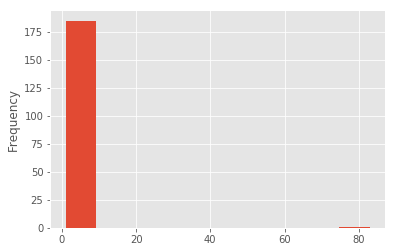

In [40]:
df_case['mail_counting'].plot.hist()

In [41]:
case_id = '0-8003000029452'
idx = df_case[df_case['case_id'] == case_id].index[0]
mail_list = df_case[df_case['case_id'] == case_id]['mail_id_list'][idx]
print(mail_list)

['17054737ef915417', '17053db44102c850', '1705367ec247d4eb', '170460c0f80b9508', '17044d25e2d71ced', '17040422301277a2']


In [42]:
df.columns

Index(['mail_id', 'thread_id', 'mail_date_received_full', 'mail_from',
       'mail_subject', 'mail_body', 'mail_body_snippet', 'has_attachment',
       'mail_date_received', 'mail_hms_received', 'case_id',
       'external_ref_number'],
      dtype='object')

In [43]:
df.columns

Index(['mail_id', 'thread_id', 'mail_date_received_full', 'mail_from',
       'mail_subject', 'mail_body', 'mail_body_snippet', 'has_attachment',
       'mail_date_received', 'mail_hms_received', 'case_id',
       'external_ref_number'],
      dtype='object')

In [44]:
PrintMail(mail_list, df)

17054737ef915417
RES: PRODUÇÃO : [0-8003000029452] c 2020/02/18 - February 18th, 2020 - CRIMINAL - GMAIL - MURDER - TRIX #8030.
2020-02-17
mohamad.fares@carinaquito.com
-----------
Oi Petrya, Considerando que o Gui vem do Mackenzie, acho perca de tempo ele ir até Guarulhos e voltar. Vamos soltar por corresp, por favor. Mais eficaz. Abs., De: Petrya Julia Zago Alves &lt;petrya.
-----------
-----------
-----------
17053db44102c850
RES: PRODUÇÃO : [0-8003000029452] c 2020/02/18 - February 18th, 2020 - CRIMINAL - GMAIL - MURDER - TRIX #8030.
2020-02-17
petrya.alves@carinaquito.com
-----------
Como essa entrega é em Guarulhos, vamos mandar correspondente ou levar até la? Pensei que como é perto do Tatuapé, as vezes o Gui podia entregar direto da casa dele de taxi e vir! O que acham? Abs De:
-----------
-----------
-----------
1705367ec247d4eb
PRODUÇÃO : [0-8003000029452] c 2020/02/18 - February 18th, 2020 - CRIMINAL - GMAIL - MURDER - TRIX #8030.
2020-02-17
mohamad.fares@carinaquito.com
---

In [45]:
df_thread = df.groupby('case_id')['thread_id'].apply(list).apply(set).to_frame().reset_index()
df_thread.columns = ['case_id', 'thread_id_list']

In [46]:
df_thread['thread_counting'] = df_thread['thread_id_list'].apply(len)

In [47]:
df_thread

,case_id,thread_id_list,thread_counting
0,,"{1703bfda1bea5a6e, 17036c4cfaa98d0b, 16f7b3a30...",32
1,0-0306000029605,"{1703109580dd8b3d, 170442f906dafea6, 170408829...",4
2,0-1173000029761,{16ffe1b58ed083a8},1
3,0-1638000029307,"{1703bab743b6f57b, 1703046c15ee7586}",2
4,0-2004000029827,{17031b1f4e310c6d},1
5,0-2143000029186,{1701d0f947e05b6a},1
6,0-4650000029571,{17040d4b973d4afa},1
7,0-6726000029339,"{17040ebdc44b9df5, 1703665bb4b249ef}",2
8,0-7209000029454,"{17034fbd4bc7926d, 1703ba85c84a0981}",2
9,0-7887000029294,{17020ba673a3be19},1


In [48]:
df_case.columns

Index(['case_id', 'mail_id_list', 'mail_counting'], dtype='object')

In [49]:
df_ct = df_case.merge(df_thread, on = 'case_id', how = 'left')

In [50]:
df_ct

,case_id,mail_id_list,mail_counting,thread_id_list,thread_counting
0,,"[170555c57e92e042, 17054fc0e1d00aef, 17054e67d...",83,"{1703bfda1bea5a6e, 17036c4cfaa98d0b, 16f7b3a30...",32
1,0-0306000029605,"[170538586376eafb, 170442f906dafea6, 170408829...",4,"{1703109580dd8b3d, 170442f906dafea6, 170408829...",4
2,0-1173000029761,[17044a5982958b3e],1,{16ffe1b58ed083a8},1
3,0-1638000029307,"[170400de25cd7dac, 1703bab743b6f57b, 1703046c1...",3,"{1703bab743b6f57b, 1703046c15ee7586}",2
4,0-2004000029827,"[1703b6729d2b3b00, 17031b1f4e310c6d]",2,{17031b1f4e310c6d},1
5,0-2143000029186,[17040c87c44516fa],1,{1701d0f947e05b6a},1
6,0-4650000029571,[17040d4b973d4afa],1,{17040d4b973d4afa},1
7,0-6726000029339,"[170553e07fbe0a9f, 17040ebdc44b9df5, 1703b0c22...",4,"{17040ebdc44b9df5, 1703665bb4b249ef}",2
8,0-7209000029454,"[1703bbe141599d65, 1703ba85c84a0981, 1703ba702...",4,"{17034fbd4bc7926d, 1703ba85c84a0981}",2
9,0-7887000029294,[1704557968c4f645],1,{17020ba673a3be19},1


In [51]:
df_ct[df_ct['thread_counting'] == 1]

,case_id,mail_id_list,mail_counting,thread_id_list,thread_counting
2,0-1173000029761,[17044a5982958b3e],1,{16ffe1b58ed083a8},1
4,0-2004000029827,"[1703b6729d2b3b00, 17031b1f4e310c6d]",2,{17031b1f4e310c6d},1
5,0-2143000029186,[17040c87c44516fa],1,{1701d0f947e05b6a},1
6,0-4650000029571,[17040d4b973d4afa],1,{17040d4b973d4afa},1
9,0-7887000029294,[1704557968c4f645],1,{17020ba673a3be19},1
13,0-9497000029450,"[17035d059d2585fe, 17030c402cb972aa]",2,{17030c402cb972aa},1
15,1-0026000029532,[170316efb1cff91e],1,{1701c919b2b408d0},1
16,1-1251000029949,[170534e2ed75df5d],1,{170534e2ed75df5d},1
17,1-2104000029366,[17045e22d1ba5777],1,{16ff91973b792221},1
18,1-2202000029393,"[1703ed98a55f752d, 17031b633ba5ef14]",2,{17031b633ba5ef14},1


In [52]:
df_ct['thread_counting'].describe()

count    186.000000
mean       1.650538
std        2.327607
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       32.000000
Name: thread_counting, dtype: float64

In [53]:
df_lawsuit = df.groupby('external_ref_number')['mail_id'].apply(list).to_frame().reset_index()
df_lawsuit.columns = ['external_ref_number', 'mail_id_list']
df_lawsuit['mail_counting'] = df_lawsuit['mail_id_list'].apply(len)

In [54]:
df_lawsuit

,external_ref_number,mail_id_list,mail_counting
0,,"[170553e07fbe0a9f, 17054fc0e1d00aef, 17054e67d...",97
1,0000032-32.2020.8.21.0070,"[1705563ce475e55b, 17053db8f407985f, 17053c55c...",4
2,0000036-20.2020.8.13.0611,"[17040cbf2a62a6cb, 17036c3c0ff7afd0, 1703017cc...",3
3,0000048-12.2020.8.26.0081,[170363ee4891f214],1
4,0000058-90.2020.8.15.0201,[170319182b157b8d],1
5,0000140-52.2020.8.26.0222,"[17036b2ad37d1262, 1702f387f18173c9]",2
6,0000142-60.2020.8.26.0177,[170406c3eb82a1e7],1
7,0000220-85.2020.8.17.1250,"[17055764b0c8abbc, 17053d2af4bb8d4d]",2
8,0000227-31.2020.8.12.0017,"[170556c15b5352c2, 170454cb663f21a3]",2
9,0000252-26.2020.8.21.0039,[17030ef74796b27b],1


In [56]:
PrintMail(df_lawsuit['mail_id_list'][138], df)

170557b2c0b460e8
PRODUÇÃO - [7-8216000029607] - LAVA JATO - FINES - c 2020/02/25 - February 25th, 2020 - CRIMINAL - FEDERAL - JFPR - GMAIL - CORRUPTION - MONEY LAUNDERING - TRIX #8075 - 3rd Request
2020-02-17
mohamad.fares@carinaquito.com
-----------
Exmo. Senhor Procurador da República da Força Tarefa Lava-Jato do Ministério Público Federal em Curitiba/PR – Dr. Antonio Augusto Teixeira Diniz Ref. Autos nº Ref. Ofício nº Local: Ministério Público
-----------
-----------
-----------
170555c775905b1f
Re: [7-8216000029607] - LAVA JATO - FINES - c 2020/02/25 - February 25th, 2020 - CRIMINAL - FEDERAL - JFPR - GMAIL - CORRUPTION - MONEY LAUNDERING - TRIX #8075 - 3rd Request
2020-02-17
lis-latam@google.com
-----------
Dear all, I have just shared Drive folder 3480672(#8075) with quito-share@googlegroups.com and Taís containing production and letters. Thanks, Alex- LIS On Wed, Feb 12, 2020 at 23:04 UTC &quot;Mohamad
-----------
-----------
-----------
1703ba56fc5f328f
[7-8216000029607] - LAVA

In [89]:
df_ct

,case_id,mail_id_list,mail_counting,thread_id_list,thread_counting
0,,"[170555c57e92e042, 17054fc0e1d00aef, 17054e67d...",7,"{17045ef91d67c32d, 17011afd9fe468e7, 17054b493...",4
1,0-0306000029605,[170538586376eafb],1,{170538586376eafb},1
2,0-6726000029339,[170553e07fbe0a9f],1,{17040ebdc44b9df5},1
3,0-8003000029452,"[17054737ef915417, 17053db44102c850, 1705367ec...",3,{1705367ec247d4eb},1
4,0-8017000029681,[17055979d4e3bddb],1,{17055979d4e3bddb},1
5,0-9698000029604,[170541c949d3054a],1,{1703b9e19856e937},1
6,1-1251000029949,[170534e2ed75df5d],1,{170534e2ed75df5d},1
7,1-2626000029620,[17053ffe53b47ca0],1,{17053ffe53b47ca0},1
8,1-5710000029265,[1705581c9417da09],1,{1705581c9417da09},1
9,1-5906000029382,[170557002cd75f98],1,{170557002cd75f98},1
